In [1]:
import os
from glob import glob
import pandas as pd 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Read data

In [3]:
data_path = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\'

In [4]:
savedirs = {'exp_0': os.path.join(data_path,'Exp0_Nov_2023'),
            'exp_1': os.path.join(data_path,'Exp1_Nov_2023'),
            # 'exp_1': os.path.join(data_path,'Exp0_Mar31'),
            # 'exp_2': os.path.join(data_path, 'Exp2-edgethr_may28'),
            'exp_2': os.path.join(data_path,'Exp2_Aug_11'),
            }

def get_results(directory, copy_columns=None):

    # Get filenames
    csv_files = [fn for fn in os.listdir(directory) if fn.endswith('.csv')]
    
    # Read csv files
    train_specs = None
    train_stats = dict()
    test_results = None
    test_stack = [] # TODO remove
    final_tests = [] # TODO remove
    for fn in csv_files:
        full_path = os.path.join(directory,fn)
        
        # Read training specificiations
        if fn.endswith('_specs.csv'):
            train_specs = pd.read_csv(full_path).set_index('model_name')
            
        # Read train stats
        if fn.endswith('_train_stats.csv'):
            model_name = fn.replace('_train_stats.csv', '')
            train_stats[model_name] = pd.read_csv(full_path)
            train_stats[model_name]['model_name'] = model_name # add as data column
            
        # Read test results
        if fn.endswith('_test_results.csv'):
        # if fn.endswith('_final_results.csv'):
            test_results = pd.read_csv(full_path).set_index('model_name')

        ### TODO remove
        if '_test_' in fn:
            model_name = fn.split('_test_')[0]
            episode = fn[-8:-4]
            test_data = pd.read_csv(full_path)
            test_data['model_name'] = model_name
            test_data['episode'] = episode
            test_stack.append(test_data)


        ### TODO remove
        if '_final_' in fn:
            model_name = fn.split('_final_')[0]
            test_data = pd.read_csv(full_path)
            test_data['model_name'] = model_name
            test_data = test_data.set_index('model_name')
            final_tests.append(test_data)

    # Copy data columns from train specs to train stats
    if copy_columns is not None and train_specs is not None:
        for model_name in train_specs.index:
            for col in copy_columns:
                if col in train_specs.columns and model_name in train_stats.keys():
                    train_stats[model_name][col] = train_specs.loc[model_name, col]

    return {'train_specs': train_specs,
            'test_results': test_results,
            'train_stats': train_stats,
            'train_stats_stacked': pd.concat(train_stats.values()),
            'test_results_stacked': pd.concat(test_stack),
            'final_tests': pd.concat(final_tests)}


indep_vars = ['gamma', 'lr_dqn', 'target_update','optimizations_per_step', 'phosphene_resolution',
              'complexity', 'edge_threshold', 'seed', 'light_intensity']



## Results Exp 1

#### Training Curves

In [18]:
results = get_results(directory=savedirs['exp_1'], copy_columns= indep_vars)
data = results['train_stats_stacked']
data = data.loc[data.validation == 1].copy()
# data['reward_avg_5'] = data.groupby('model_name').reward.rolling(5,center=False).mean().values
# data['reward_avg_10'] = data.groupby('model_name').reward.rolling(10,center=False).mean().values
# # data = data.set_index('model_name')

# mask = (data.seed==0) & (data.complexity=='complex')
# sns.lineplot(data=data.fillna(0).loc[mask],
#              hue='phosphene_resolution', y='reward_avg_10', x='episode')

#### Test results

In [40]:
all_test_results = results['test_results_stacked']
best_idx = all_test_results.groupby(['model_name','episode']).cumulative_reward.idxmax()
best_result = all_test_results.set_index(['model_name','episode']).loc[best_idx.index]


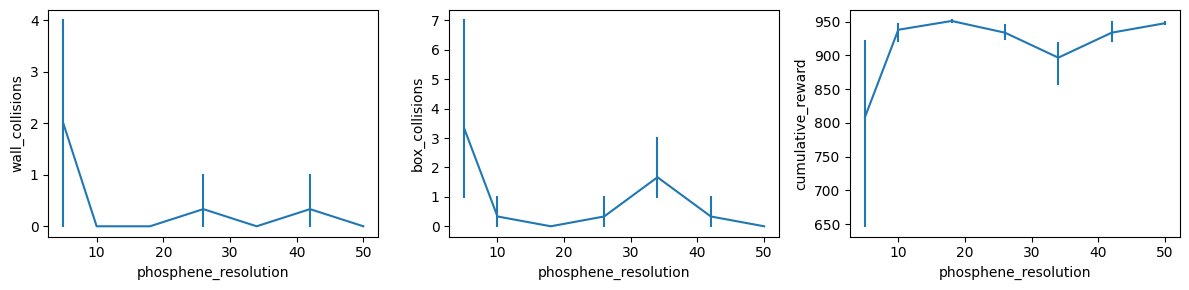

In [46]:
data= results['final_tests']
for y in indep_vars:
    data[y] = results['train_specs'].loc[data.index,y].values
dep_vars =  ['wall_collisions', 'box_collisions', 'cumulative_reward'] # 'endless_loops', 'step_count',
n_figs = len(dep_vars)

fig, axs = plt.subplots(1,n_figs, figsize=(4*n_figs, 3))
for i,y in enumerate(dep_vars):
    sns.lineplot(data=data, x='phosphene_resolution', y=y, ax=axs[i], err_style='bars')
    # axs[i].get_legend().set_title('Env. Complexity')
plt.tight_layout()

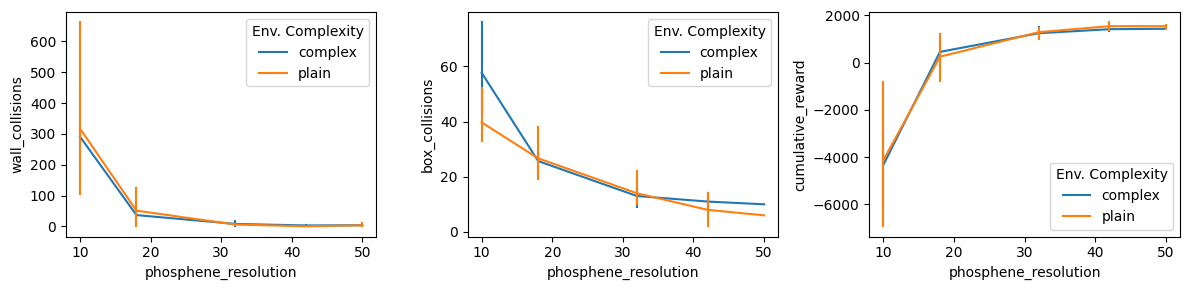

In [154]:
data=results['test_results']
dep_vars =  ['wall_collisions', 'box_collisions', 'cumulative_reward'] # 'endless_loops', 'step_count',
n_figs = len(dep_vars)

fig, axs = plt.subplots(1,n_figs, figsize=(4*n_figs, 3))
for i,y in enumerate(dep_vars):
    sns.lineplot(data=data, x='phosphene_resolution', y=y, ax=axs[i], hue='complexity', err_style='bars')
    axs[i].get_legend().set_title('Env. Complexity')
plt.tight_layout()

## Results Experiment 2

### test results

In [185]:
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
final_tests = results['final_tests']
train_specs = results['train_specs']

# Copy data columns from train specs to train stats
for model_name in train_specs.index:
    for col in indep_vars:
        if col in train_specs.columns and model_name in final_tests.index:
            final_tests.loc[model_name,col] = train_specs.loc[model_name, col]

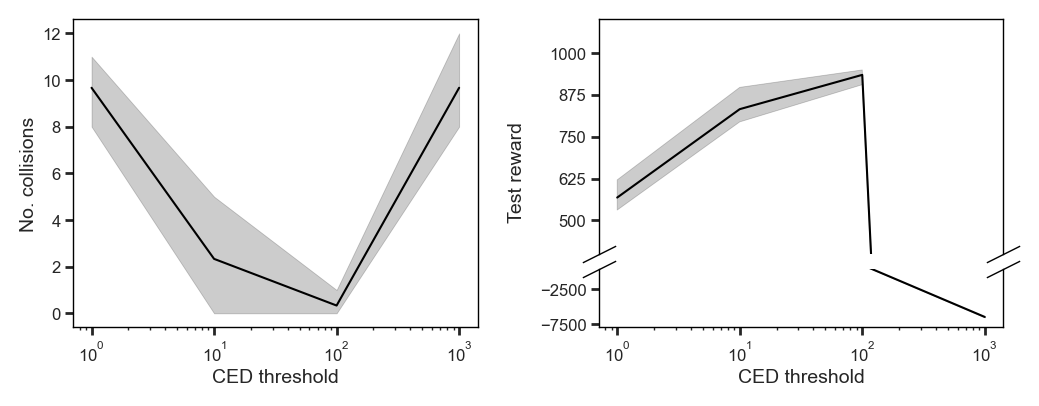

In [187]:
import visualization
import importlib
importlib.reload(visualization)
visualization.set_figurestyle()

endpoints = ['box_collisions', 'cumulative_reward']
ylabels = ['No. collisions', 'Test reward']
xlabel = 'CED threshold'

fig = plt.figure(figsize=(6,2),dpi=200)
gs = matplotlib.gridspec.GridSpec(2, 2,height_ratios=[4,1], hspace=0.1, wspace=0.3, figure=fig)  

ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])

## Axs 0 (left panel)
sns.lineplot(data=final_tests, x='edge_threshold', y=endpoints[0], ax=ax0, color='k')
ax0.set(xscale='log',
        xlabel = xlabel,
        ylabel = ylabels[0])


## Axs 1+2 (right panel)
sns.lineplot(data=final_tests, x='edge_threshold', y=endpoints[1], ax=ax1, color='k')
sns.lineplot(data=final_tests, x='edge_threshold', y=endpoints[1], ax=ax2, color='k')


ax2.set(ylim=[-8000, 400],
        xscale = 'log',
        ylabel= '',
        xlabel=xlabel,
        yticks = [-2500, -7500]) 

ax1.set(ylim=[400, 1100],
        xscale = 'log',
        xlabel='',
        ylabel=ylabels[1],
        yticks= np.linspace(500,1000,5)) 
ax1.yaxis.set_label_coords(-.18, 0.35)

# Remove spines and ticks
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

# Add break lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=0.5, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.savefig("figures/exp2_results.png", bbox_inches='tight')

### Test loop

#### Configure test setup

In [34]:
import sys
import torch
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # local files
sys.path.insert(0, '../')
import model
import imgproc
import pyClient 
import testing
import utils

save_directory = savedirs['exp_2']
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])

In [99]:
# Load previous test results
if os.path.exists(os.path.join(save_directory,'_test_results.csv')):
    test_results = pd.read_csv(os.path.join(save_directory,'_test_results.csv')).fillna(np.nan).replace([np.nan], [None]).set_index('model_name')
    todo = train_specs.loc[~train_specs.index.isin(test_results.index)]
    print('found previous test results (appending new ones)')
else: 
    test_results = None
    todo = train_specs

#### Can be removed (assuming that all models are finished training)
todo = todo.loc[todo.status == 'finished'].copy()

# Load all checkpoints per model
checkpoints = dict()
for model_name in todo.index:
    checkpoints[model_name] = sorted(glob(f'{save_directory}/{model_name}_*.pth'))

test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

print('todo:\n' + '\n'.join(todo.index))

todo:
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_100
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1000
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_100


In [100]:
test(agent, environment, img_processing, cfg, store_replay=False, store_Q_predictions=False)

#### Test run

In [107]:
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch


test_data = []
environment_connected = False
for _ , cfg in todo.iterrows():
    current_model = cfg.name

    print(current_model)
    # Additional training settings (inferred from specified settings)
    cfg.update(test_cfg)
    cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
    cfg['model_path']         = checkpoints[current_model][-1] #os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
    cfg['model_name']         = current_model

    # Initialize model components
    img_processing = imgproc.ImageProcessor(**cfg)
    environment =  pyClient.Environment(**cfg) if not environment_connected else environment # Only initialized on first run

    agent = model.DoubleDQNAgent(**cfg)
    agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
    agent.policy_net.eval()
    
    
    # # Training
    assert environment.client is not None, "Error: could not connect to env. Make sure to start Unity server first!"
    environment_connected = True

    results = test(agent, environment, img_processing, cfg, store_replay=True, store_Q_predictions=True)
    test_data.append({**cfg,**results})


    # write replay memory to video
    # videopath = os.path.join(OUT_PATH,'{}.avi'.format(current_model))
    # utils.save_replay(agent.memory.memory, videopath,(cfg['imsize'], cfg['imsize']))
# data = pd.DataFrame(test_data)
# data.to_csv(os.path.join(OUT_PATH,'_test_results.csv'), index=False)

if test_results is None:
    test_results = pd.DataFrame(test_data).set_index('model_name')
else:
    test_results = pd.concat([test_results,pd.DataFrame(test_data).set_index('model_name')])
# test_results.to_csv(os.path.join(OUT_PATH,'_test_results.csv'))

exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_100
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1000
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_100


In [108]:
test_results = pd.DataFrame(test_data).set_index('model_name')
test_results.to_csv(os.path.join(save_directory,'_test_results.csv'))

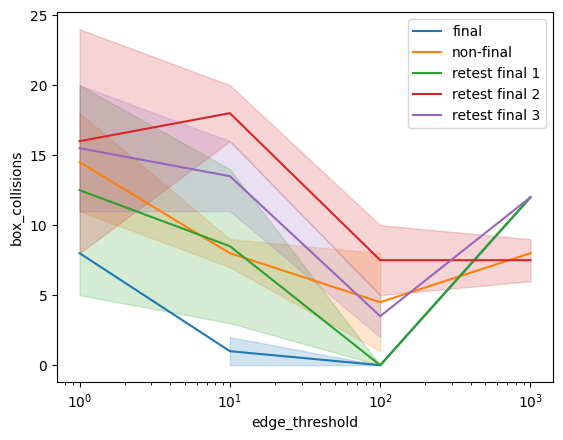

In [113]:
# From test results during training (final model, different machine)
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
data = results['final_tests']
data['edge_threshold'] = results['train_specs'].loc[data.model_name, 'edge_threshold'].values
sns.lineplot(data=data, x='edge_threshold', y='box_collisions', label='final')

# Test results of saved model (tested on current machine. Is not the final model but the 'best' model) 
test_results_non_final = pd.read_csv(os.path.join(save_directory, '_test_results_non-final.csv'))
sns.lineplot(data=test_results_non_final, x='edge_threshold', y='box_collisions', label='non-final')

# Test results of saved model (tested on current machine. Final saved model) 
test_results_1 = pd.read_csv(os.path.join(save_directory, '_test_results_1.csv'))
sns.lineplot(data=test_results_1, x='edge_threshold', y='box_collisions', label='retest final 1')

# Test results of saved model (tested on current machine. Final saved model) 
test_results_2 = pd.read_csv(os.path.join(save_directory, '_test_results_2.csv'))
sns.lineplot(data=test_results_2, x='edge_threshold', y='box_collisions', label='retest final 2')

# Test results of saved model (tested on current machine. Final saved model) 
test_results_3 = pd.read_csv(os.path.join(save_directory, '_test_results_3.csv'))
sns.lineplot(data=test_results, x='edge_threshold', y='box_collisions', label='retest final 3')


plt.xscale('log')

<Axes: xlabel='episode', ylabel='reward_avg_10'>

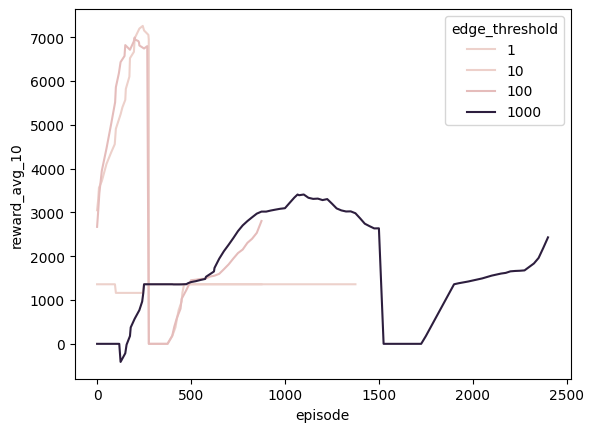

In [32]:
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
data = results['train_stats_stacked']
data = data.loc[data.validation == 1].copy()
data['reward_avg_5'] = data.groupby('model_name').reward.rolling(5,center=False).mean().values
data['reward_avg_10'] = data.groupby('model_name').reward.rolling(10,center=False).mean().values
# data = data.set_index('model_name')

mask = (data.seed==0) & (data.complexity=='plain')
sns.lineplot(data=data.fillna(0).loc[mask],
             hue='edge_threshold', y='reward_avg_10', x='episode')

# Baseline model

## Baseline results

In [160]:
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.loc[train_specs.status=='finished'].copy()
final_tests = results['final_tests']
train_stats = results['train_stats']


# Copy data columns from train specs to train stats
for model_name in train_specs.index:
    for col in indep_vars:
        if col in train_specs.columns and model_name in final_tests.index:
            final_tests.loc[model_name,col] = train_specs.loc[model_name, col]


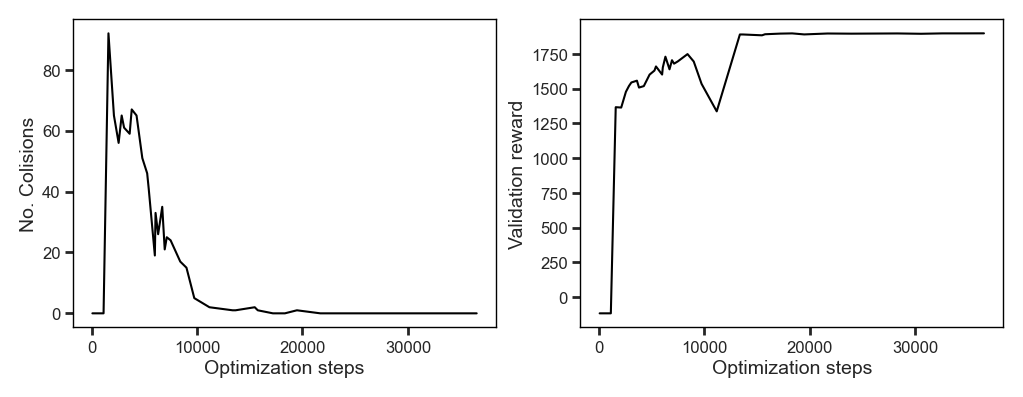

In [297]:
# Baseline model
model_name = "exp0-nov2023_comp_plain-seed_0-mode_camera-vision"
data = train_stats[model_name]

data['optimization_steps'] = data.loc[data.validation==0].step_count.cumsum()
data['optimization_steps'] = data.optimization_steps.ffill()
data['validation_reward'] = data.loc[data.validation==1, 'reward'] / 5

endpoints = ['box_collisions', 'validation_reward']
ylabels = ['No. Colisions', 'Validation reward']
xlabel =  'Optimization steps'


visualization.set_figurestyle()
fig, axs = plt.subplots(1,2, figsize=(6,2), dpi=200)
for i, y in enumerate(endpoints):
    sns.lineplot(data=data.loc[data.validation==1], y=y, x='optimization_steps', color='k', ax=axs[i])
    axs[i].set(ylabel = ylabels[i],
               xlabel = xlabel)

fig.savefig('figures/exp0_baseline.png', bbox_inches='tight')

## Example run

In [4]:
save_directory = savedirs['exp_0']
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])

In [5]:
# Load all checkpoints per model
checkpoints = dict()
finished = train_specs.loc[train_specs.status == 'finished']
for model_name in finished.index:
    checkpoints[model_name] = sorted(glob(f'{save_directory}/{model_name}_*.pth'))

test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

print('finished models:\n' + '\n'.join(finished.index))

finished models:
exp0-nov2023_comp_plain-seed_0-mode_camera-vision


In [6]:
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch
import cv2
from testing import test

cfg = finished.iloc[0].copy()

current_model = cfg.name

# Additional training settings (inferred from specified settings)
cfg.update(test_cfg)
cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
cfg['model_path']         = checkpoints[current_model][-1] #os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
cfg['model_name']         = current_model

# Initialize model components
img_processing = imgproc.ImageProcessor(**cfg)
environment =  pyClient.Environment(**cfg) 

agent = model.DoubleDQNAgent(**cfg)
agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
agent.policy_net.eval()

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=5408, out_features=3, bias=True)
)

In [8]:
with torch.no_grad():
    testing_results = test(agent, environment, img_processing, cfg, store_replay=True, store_Q_predictions=True)

In [9]:
testing_results

{'wall_collisions': 0,
 'box_collisions': 1,
 'endless_loops': 0,
 'step_count': 650,
 'cumulative_reward': 5436.0}

In [10]:
q_values = agent.Q_predictions
q0, q1, q2 = torch.stack(q_values).squeeze().split(1,dim=1)


# Infer x and y locations based on actions
actions = []
x_pos, y_pos = [], []
states = []
x = 0
y = 1
for i, (s_i, a, s_next, r) in enumerate(agent.memory.memory):
    action = a.item()
    actions.append(action)
    if a == 0:
        x += 1
    elif a == 1:
        y = min(2,y+1)
    else:
        y = max(0,y-1)
    states.append(s_i.numpy().squeeze()[-1])
    y_pos.append(y)
    x_pos.append(x)
x_pos = np.array(x_pos)#*0.95
y_pos = np.array(y_pos)#*0.5

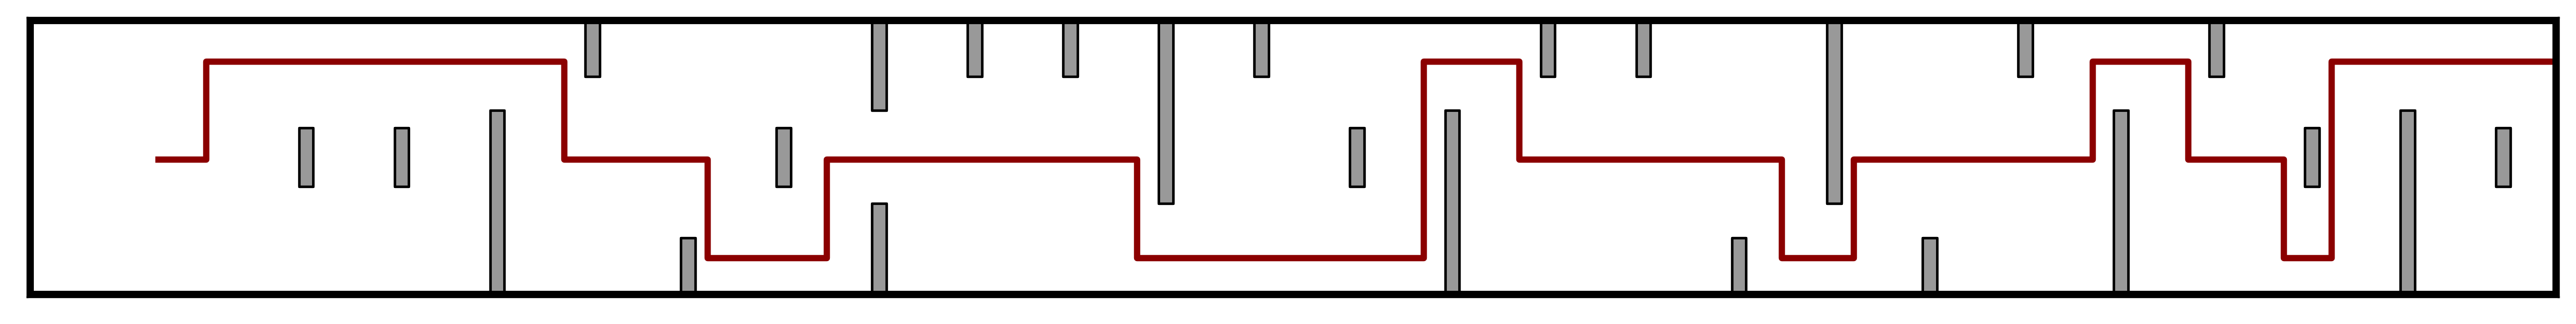

In [48]:
from env_params import get_hallway_layouts
from matplotlib.patches import Rectangle
import visualization

## Plot test hallway
# importlib.reload(env_params)
# importlib.reload(visualization)
fig, ax = plt.subplots(1,1, figsize=(18,2),dpi=300)
hallways = get_hallway_layouts()
visualization.plot_hallway(hallways['test_hallway'], ax=ax)

n = 200

# Plot trajectory
ax.plot(((x_pos[:n]+4.5)*.5),y_pos[:n]+.4, color = '#8b0000',linewidth=2.5)
ax.set_xlim([0,53])

# ## Color with Q values
# color = q0 - (q1 + q2)
# color = ((color-color.min())/(color.max()-color.min())).numpy().squeeze()
# # color = color.tolist()
# # norm = plt.Normalize(color.min(), color.max())

# points = np.array([(x_pos[:n]+4.5)*.5, y_pos[:n]+.4]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)
# lc = matplotlib.collections.LineCollection(segments, cmap='cividis')
# lc.set_array(color[2:n+2])
# lc.set_linewidth(3)
# handle = ax.add_collection(lc)

## Border around plot
rect = Rectangle((0,0),53, 2.85, facecolor='none', edgecolor='k', linewidth=5, zorder=10)
ax.add_patch(rect)

# fig.savefig('figures/test_trajectory.png', bbox_inches='tight')

## Perturbation Analysis

#### Setup test config

In [192]:
save_directory = savedirs['exp_0']
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])

In [195]:
# Load all checkpoints per model
checkpoints = dict()
finished = train_specs.loc[train_specs.status == 'finished']
for model_name in finished.index:
    checkpoints[model_name] = sorted(glob(f'{save_directory}/{model_name}_*.pth'))

test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

print('finished models:\n' + '\n'.join(finished.index))

finished models:
exp0-nov2023_comp_plain-seed_0-mode_camera-vision


In [200]:
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch
import cv2
import pickle

cfg = finished.iloc[0].copy()

current_model = cfg.name

# Additional training settings (inferred from specified settings)
cfg.update(test_cfg)
cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
cfg['model_path']         = checkpoints[current_model][-1] #os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
cfg['model_name']         = current_model

# Initialize model components
img_processing = imgproc.ImageProcessor(**cfg)
environment =  pyClient.Environment(**cfg) 

agent = model.DoubleDQNAgent(**cfg)
agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
agent.policy_net.eval()

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=5408, out_features=3, bias=True)
)

#### Obtain the state to be evaluated

In [259]:

# # Reset environment at start of episode
# _, _, _ = environment.reset(cfg['training_condition']+2)

# # Create an empty frame stack and fill it with frames
# frame_stack = imgproc.FrameStack(stack_size=cfg['stack_size'] )
# for _ in range(cfg['stack_size'] ):
#     _, _, frame_raw = environment.step(0)
#     frame = img_processing(frame_raw).to(agent.device)
#     state = frame_stack.update_with(frame)


# plt.imshow(frame_raw['colors'])

In [84]:
## Perform additional steps
# _, _, frame_raw = environment.step(0)
# frame = img_processing(frame_raw).to(agent.device)
# state = frame_stack.update_with(frame)


In [199]:
## Save state and last frame
# with open('figures/example_frame.pickle', 'wb') as handle:
#     pickle.dump(frame_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(state, "figures/example_state.pt")

In [256]:
# Load state and last frame
with open('figures/example_frame.pickle', 'rb') as handle:
    frame_raw = pickle.load(handle)

state = torch.load("figures/example_state.pt")

#### Perform systematic perturbation

In [135]:
x = 0 
y = 0

def perturbator(simulator, pert_type="black"):
    def wrapper(frame):
        SIZE = 30
        
        # Perturb
        frame_ = frame.copy()

        msk = np.ones((128,128))
        msk = cv2.circle(msk, (x,y), SIZE, 0, -1) 

        # Default: draw a black circle
        frame_ = frame * msk
            
        if pert_type == "loc_avg":
            local_avg = np.mean(frame[(1-msk).astype(bool)]) # calc local avg
            frame_ += (1-msk) * local_avg # fill circle with local avg
        elif pert_type == "gray":
            frame_ += (1-msk) * 155
            
        # simulate
        return simulator(frame_.astype('uint8'))
    return wrapper

# Create image processing module from config
perturbed_proc = imgproc.ImageProcessor(**cfg)

# If current condition configures no SPV add identity func as simulator
if cfg.phosphene_resolution is None:
    perturbed_proc.simulator = lambda x:x

# Wrap the phosphene simulator with the image perturbation
perturbed_proc.simulator = perturbator(perturbed_proc.simulator, pert_type="loc_avg")



In [136]:
# Save perturbation data 
pert_data = pd.DataFrame()

# Obtain baseline results first
with torch.no_grad():
    base_q = agent.policy_net(state).squeeze().numpy()

# Perform perturbation
with torch.no_grad():
    state_ = state.clone()

    # For each coordinate in a grid 
    n_per_axis = 64 # 32 x 32 grid points
    interval, step = np.linspace(0,128,n_per_axis, endpoint=False, retstep=True)
    interval = (interval+.5*step).astype(int)
    i = 0
    for x in interval:
        for y in interval:

            # perform_perturbation and calculate Q-values
            state_[0,-1] = perturbed_proc(frame_raw)
            q_values = agent.policy_net(state_).squeeze().numpy()
            q_diff = (q_values - base_q) / base_q

            # Store output data
            pert_data.loc[i, ['q0', 'q1', 'q2']] = q_values
            pert_data.loc[i, ['q_diff0', 'q_diff1', 'q_diff2']] = q_diff
            pert_data.loc[i, ['mean_abs_diff']] = np.abs(q_diff).mean()
            pert_data.loc[i, ['x', 'y']] = x, y
            
            i += 1

In [137]:
pert_heatmap = np.zeros((128,128))
q0_heatmap = np.zeros((128,128))
q1_heatmap = np.zeros((128,128))
q2_heatmap = np.zeros((128,128))
for i, row in pert_data.iterrows():

    SIZE = 10
    
    y_min = np.max([0, row.y - SIZE]).astype(int)
    x_min = np.max([0, row.x - SIZE]).astype(int)
    y_max = np.min([127, row.y + SIZE]).astype(int)
    x_max = np.min([127, row.x + SIZE]).astype(int)
    
    pert_heatmap[y_min:y_max, x_min:x_max] += row.mean_abs_diff
    q0_heatmap[y_min:y_max, x_min:x_max] += row.q_diff0
    q1_heatmap[y_min:y_max, x_min:x_max] += row.q_diff1
    q2_heatmap[y_min:y_max, x_min:x_max] += row.q_diff2
    # print(f"{x_min}:{x_max}, {y_min}:{y_max} {row.mean_abs_diff}")

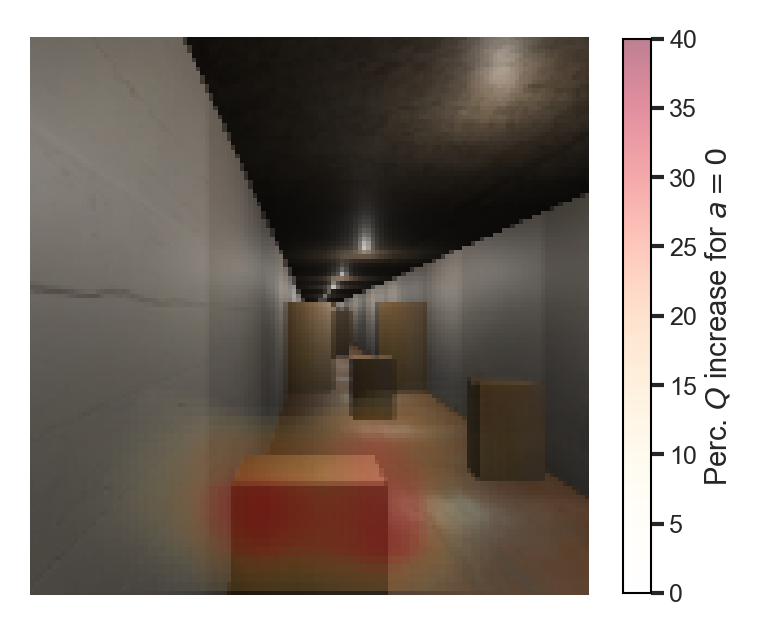

In [200]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# Choose colormap
# cmap = pl.cm.coolwarm

# # Diverging
# cmap = pl.cm.RdBu_r

# # Set alpha
# my_cmap = cmap(np.arange(cmap.N))
# my_cmap[:,-1] = np.abs(np.linspace(-.5, .5, cmap.N))
# my_cmap = ListedColormap(my_cmap)

# Diverging
cmap = pl.cm.YlOrRd

# Set alpha
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 0.50, cmap.N)
my_cmap = ListedColormap(my_cmap)

visualization.set_figurestyle()
fig = plt.figure(figsize=(3,3), dpi=300)
plt.imshow(frame_raw['colors'], alpha=1.)
plt.imshow(q0_heatmap.clip(0,np.inf), cmap=my_cmap, vmin=0, vmax=40)






plt.colorbar(shrink=0.8, label="Perc. $Q$ increase for $a=0$")
plt.axis('off')
fig.savefig("figures/positive_pert_a0.png", bbox_inches='tight')

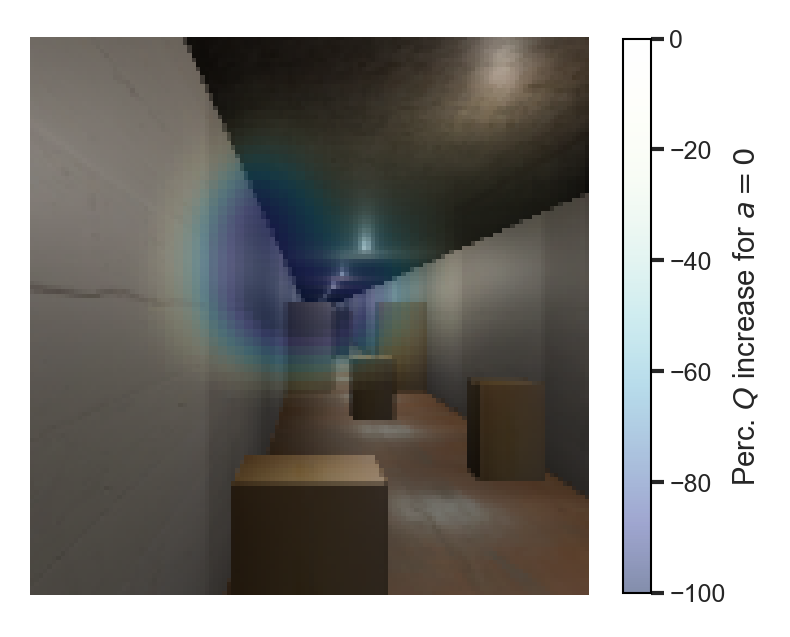

In [209]:
visualization.set_figurestyle()

# Diverging
cmap = pl.cm.YlGnBu_r

# Set alpha
# Set alpha
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0.5, 0, cmap.N)
my_cmap = ListedColormap(my_cmap)

fig = plt.figure(figsize=(3,3), dpi=300)
plt.imshow(frame_raw['colors'], alpha=1.)
plt.imshow(q0_heatmap.clip(-np.inf,0), cmap=my_cmap, vmin=-100, vmax=0)
plt.colorbar(shrink=0.8, label="Perc. $Q$ increase for $a=0$")
plt.axis('off')

fig.savefig("figures/negative_pert_a0.png", bbox_inches='tight')

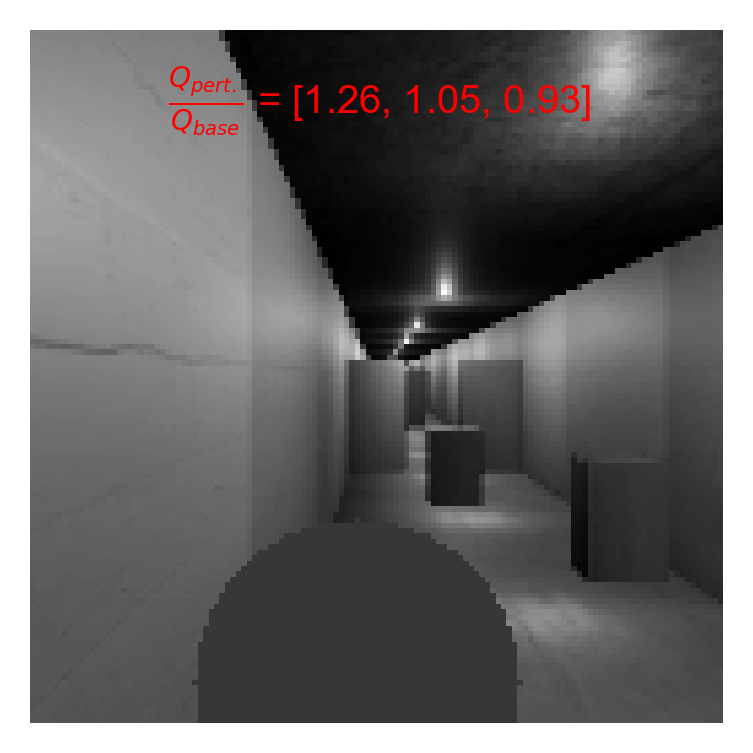

In [252]:
x= 60
y= 120


fig = plt.figure(figsize=(3,3), dpi=300)
state_[0,-1] = perturbed_proc(frame_raw)
plt.imshow(state_[0,-1].squeeze(), cmap='gray')

with torch.no_grad():
    base_q = agent.policy_net(state).squeeze().numpy()
    pert_q = agent.policy_net(state_).squeeze().numpy()

plt.axis('off')

# plt.text(3,8,"$Q_{base}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*base_q), color="r")
# plt.text(3,20,"$Q_{pert.}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*pert_q), color="r")
plt.text(25,15,r"$\frac{Q_{pert.}}{Q_{base}}$ = "+"[{:.2f}, {:.2f}, {:.2f}]".format(*(pert_q/base_q)), color="r")
fig.savefig("figures/pert_example_pos.png", bbox_inches='tight')

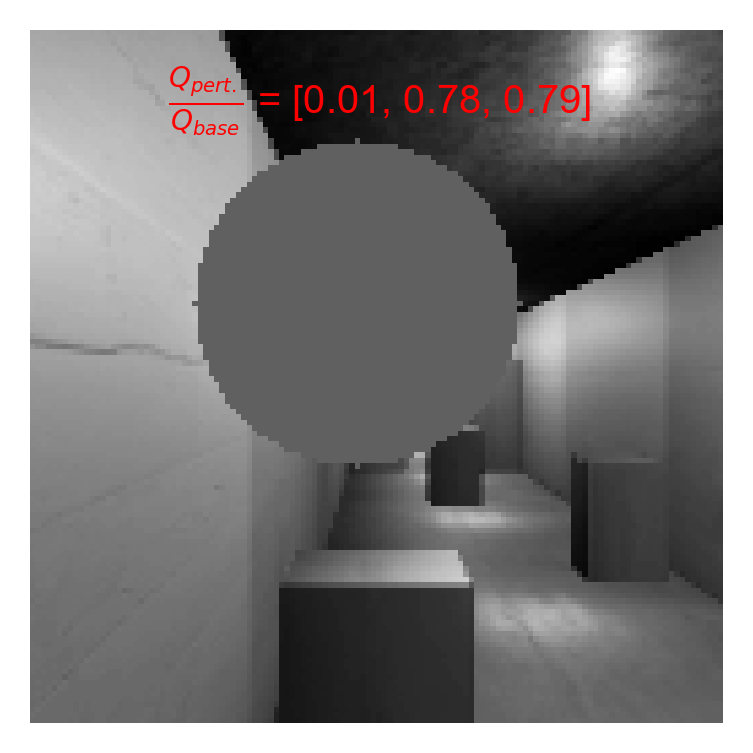

In [251]:
x= 60
y= 50


fig = plt.figure(figsize=(3,3), dpi=300)
state_[0,-1] = perturbed_proc(frame_raw)
plt.imshow(state_[0,-1].squeeze(), cmap='gray')

with torch.no_grad():
    base_q = agent.policy_net(state).squeeze().numpy()
    pert_q = agent.policy_net(state_).squeeze().numpy()

plt.axis('off')

# plt.text(3,8,"$Q_{base}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*base_q), color="r")
# plt.text(3,20,"$Q_{pert.}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*pert_q), color="r")
plt.text(25,15,r"$\frac{Q_{pert.}}{Q_{base}}$ = "+"[{:.2f}, {:.2f}, {:.2f}]".format(*(pert_q/base_q)), color="r")
fig.savefig("figures/pert_example_neg.png", bbox_inches='tight')

#### Additional image processing examples

In [261]:
# Load state and last frame
with open('figures/example_frame.pickle', 'rb') as handle:
    frame_raw = pickle.load(handle)

state = torch.load("figures/example_state.pt")


In [307]:
cfg_ = cfg.copy()
cfg_["mode"] = 'edge-detection'
cfg_["phosphene_resolution"] = None

edges = [frame_raw['colors']]
for threshold in [5, 100, 500]:
    cfg_["edge_threshold"] = threshold

    # Create image processing module from config
    proc = imgproc.ImageProcessor(**cfg_)

    img = proc(frame_raw)
    edges.append(img.squeeze())

cfg_["edge_threshold"] = 90

resolutions = [frame_raw['colors']]
for resolution in [18, 34, 50]:
    cfg_["phosphene_resolution"] = resolution

    # Create image processing module from config
    proc = imgproc.ImageProcessor(**cfg_)

    img = proc(frame_raw)
    resolutions.append(img.squeeze())

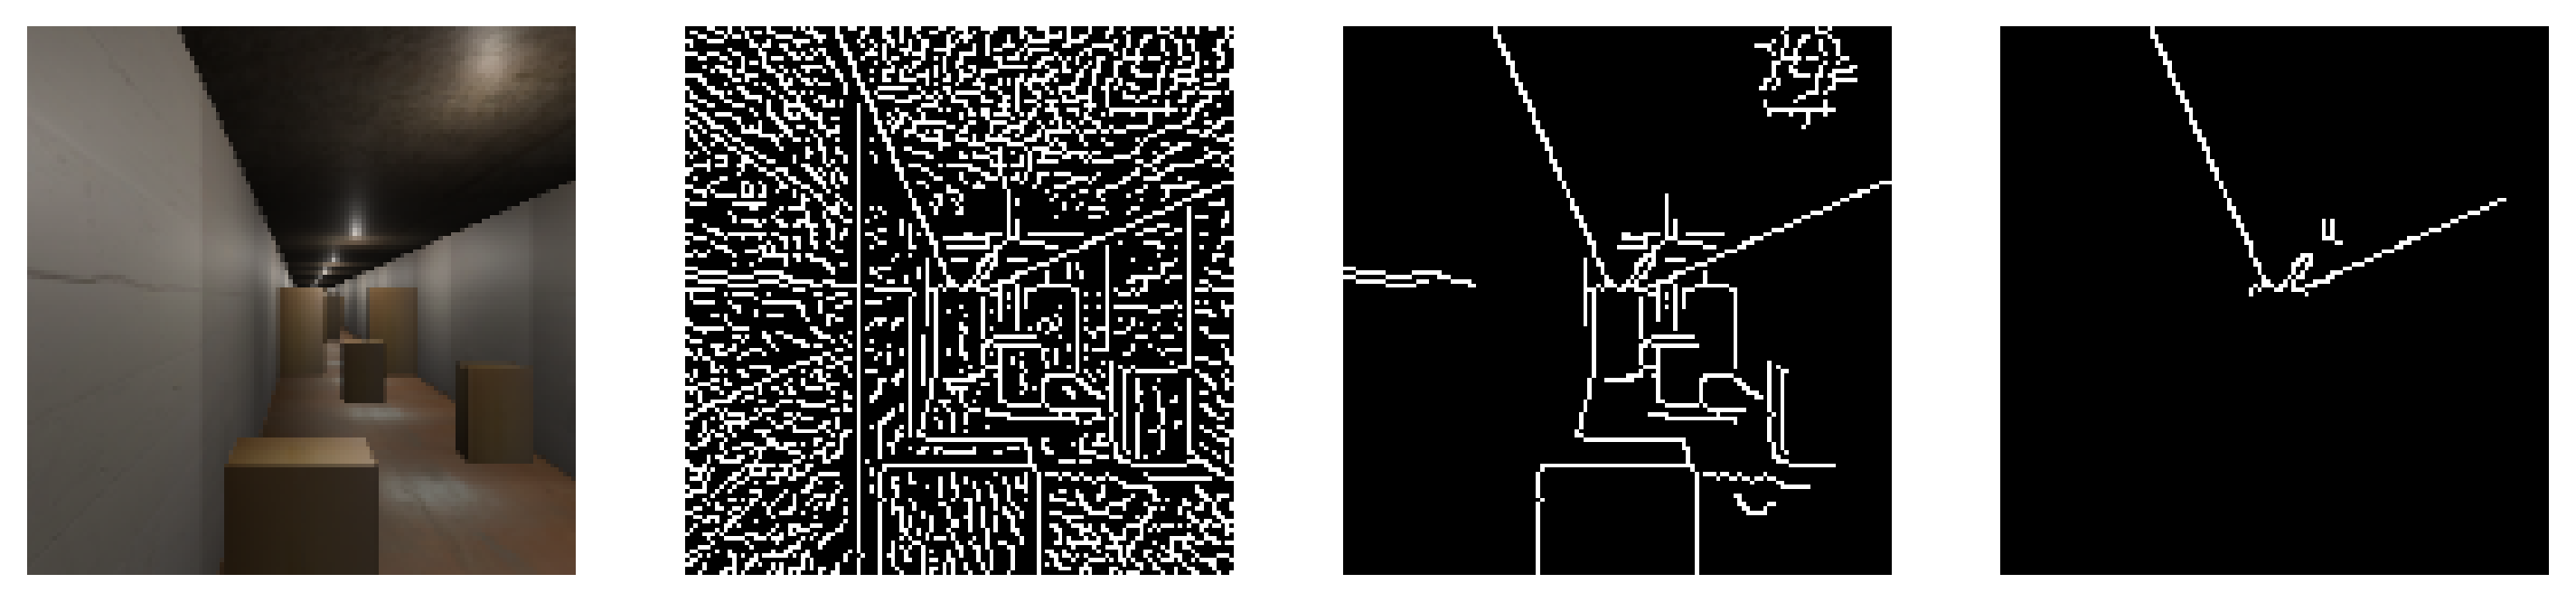

In [303]:
n_figs = len(edges)
fig, axs = plt.subplots(1,n_figs,figsize=(3*n_figs,3), dpi=300)
for i, img in enumerate(edges):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

fig.savefig("figures/edge_thresholds_5_100_500.png", bbox_inches="tight")

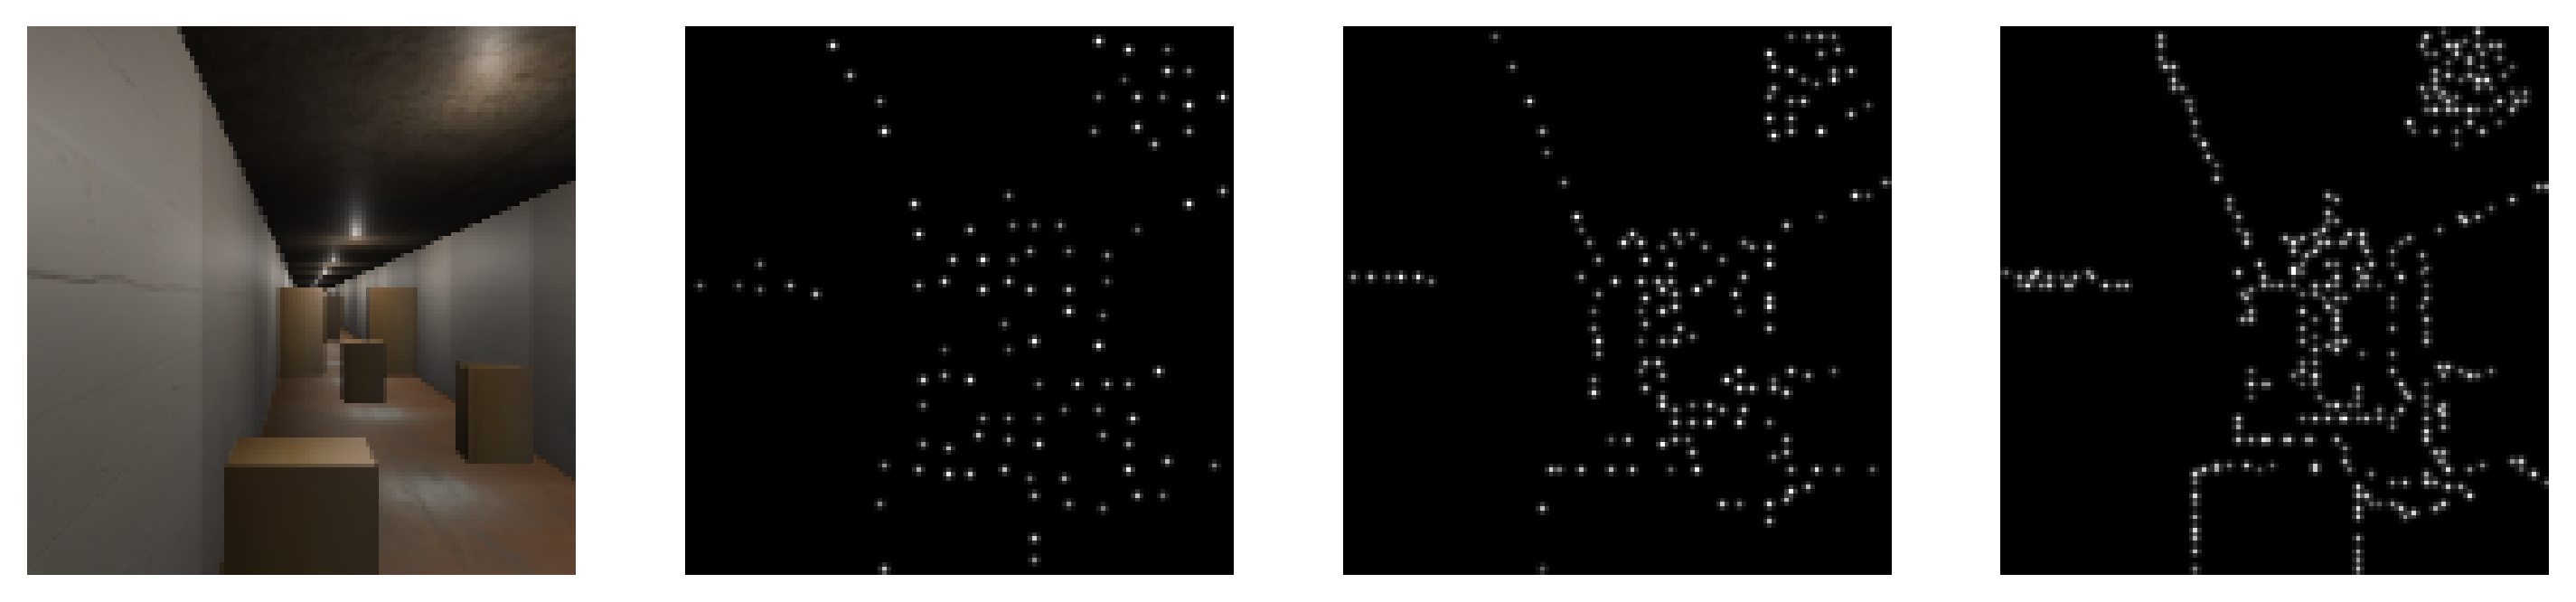

In [308]:
n_figs = len(resolutions)
fig, axs = plt.subplots(1,n_figs,figsize=(3*n_figs,3), dpi=300)
for i, img in enumerate(resolutions):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

fig.savefig("figures/resolutions_18_34_50.png", bbox_inches="tight")

## Old Code

In [3]:
# # Read train specifications
# specs_file = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Feb28\\_specs.csv'
# tsa = pd.read_csv(specs_file).set_index('model_name')
# # Read train specifications
# specs_file = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Feb28\\_specs_c.csv'
# tsb = pd.read_csv(specs_file).set_index('model_name')

In [4]:
# all_specs = tsa.append(tsb)
# all_specs = all_specs[~all_specs.index.duplicated(keep='first')]
# all_specs.to_csv('C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Feb28\\_allSpecs.csv')

In [5]:
# train_specs = all_specs.reset_index()

In [6]:
# Read train specifications
OUT_PATH = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Mar31'
specs_file = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Mar31\\_specs.csv'
train_specs = pd.read_csv(specs_file)

In [7]:
# # Append new train specs from different file
# new_specs_file = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Feb28\\_Specs.csv'
# new_specs = pd.read_csv(new_specs_file)
# train_specs = train_specs.append(new_specs.loc[~new_specs.model_name.isin(train_specs.model_name)])
# train_specs.to_csv(specs_file, index=False)

In [8]:
all_stats = pd.DataFrame()
best_stats = pd.DataFrame()

for i, cfg in train_specs.iterrows():
    model_name = cfg.model_name
    print(model_name)
    train_stats = pd.read_csv(os.path.join(OUT_PATH,'{}_train_stats.csv'.format(model_name)))
    train_stats['gamma'] = cfg.gamma
    train_stats['learning_rate'] = cfg.lr_dqn
    train_stats['model_name'] = model_name
    train_stats['target_update'] = cfg.target_update
    train_stats['optimizations_per_step'] = cfg.optimizations_per_step
    train_stats['phosphene_resolution'] = cfg.phosphene_resolution
    train_stats['complexity'] = cfg.complexity
    train_stats['edge_threshold'] = cfg.edge_threshold
    train_stats['seed'] = cfg.seed
    train_stats['light_intensity'] = cfg.light_intensity
    
    tr_msk = train_stats['validation']==0
          
    train_stats.loc[tr_msk,'smooth_reward']  = np.convolve(train_stats.loc[tr_msk].reward,np.ones(20)/20,mode='same')
    train_stats.loc[tr_msk,'smooth_loss']  = np.convolve(train_stats.loc[tr_msk].train_loss,np.ones(20)/20,mode='same')
    train_stats.loc[tr_msk,'cumulative_reward'] = train_stats.loc[tr_msk].reward.cumsum()
    
    n_optimizations = (train_stats.loc[tr_msk].step_count.cumsum() -cfg.replay_start_size).clip(0) * cfg.optimizations_per_step
    train_stats.loc[tr_msk, 'n_optimizations'] = n_optimizations
    train_stats.loc[tr_msk, 'target_net_updated'] = (n_optimizations - (n_optimizations%cfg.target_update)).diff() > 0
    
    
    # append all rows
    all_stats = all_stats.append(train_stats,ignore_index=True)

    # append only best-performing validation row
    val = train_stats.loc[train_stats.validation==1].reset_index()


    best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)

exp0_comp_complex-seed_0-phos_10-edge_120
exp0_comp_complex-seed_0-phos_18-edge_120
exp0_comp_complex-seed_0-phos_32-edge_120
exp0_comp_complex-seed_0-phos_42-edge_120
exp0_comp_complex-seed_0-phos_50-edge_120
exp0_comp_complex-seed_0-phos_none-edge_120
exp0_comp_complex-seed_1-phos_10-edge_120
exp0_comp_complex-seed_1-phos_18-edge_120
exp0_comp_complex-seed_1-phos_32-edge_120
exp0_comp_complex-seed_1-phos_42-edge_120
exp0_comp_complex-seed_1-phos_50-edge_120
exp0_comp_complex-seed_1-phos_none-edge_120
exp0_comp_complex-seed_2-phos_10-edge_120
exp0_comp_complex-seed_2-phos_18-edge_120
exp0_comp_complex-seed_2-phos_32-edge_120
exp0_comp_complex-seed_2-phos_42-edge_120
exp0_comp_complex-seed_2-phos_50-edge_120
exp0_comp_complex-seed_2-phos_none-edge_120
exp0_comp_plain-seed_0-phos_10-edge_120
exp0_comp_plain-seed_0-phos_18-edge_120
exp0_comp_plain-seed_0-phos_32-edge_120
exp0_comp_plain-seed_0-phos_42-edge_120
exp0_comp_plain-seed_0-phos_50-edge_120
exp0_comp_plain-seed_0-phos_none-edge_

10.0


KeyboardInterrupt: 

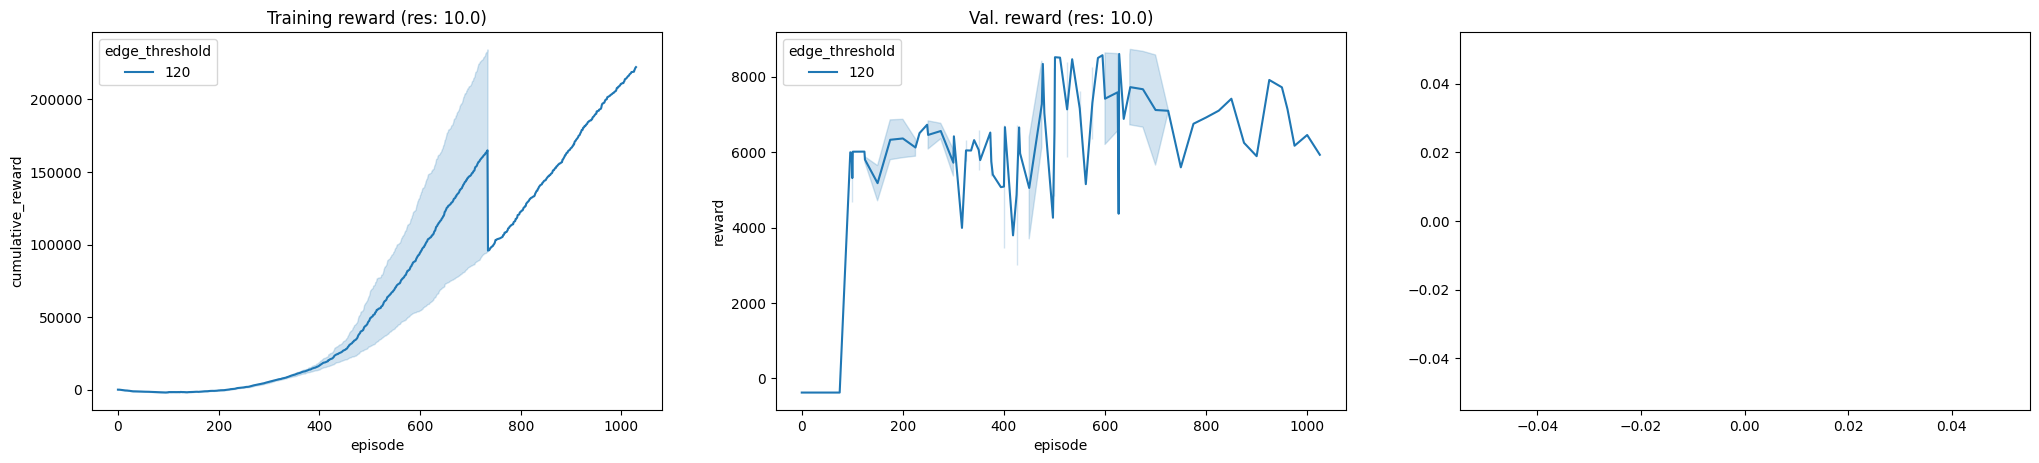

In [9]:
models = all_stats.model_name.unique()
# ['exp0_comp_complex-seed_1-phos_18-edge_90',
#        'exp0_comp_complex-seed_1-phos_18-edge_120',
#        'exp0_comp_complex-seed_1-phos_18-edge_140',
#        'exp0_comp_complex-seed_1-phos_18-edge_170',
#        'exp0_comp_complex-seed_1-phos_18-edge_230',
#        'exp0_comp_complex-seed_1-phos_42-edge_90',
#        'exp0_comp_complex-seed_1-phos_42-edge_120',
#        'exp0_comp_complex-seed_1-phos_42-edge_140',
#        'exp0_comp_complex-seed_1-phos_42-edge_170',
#        'exp0_comp_complex-seed_1-phos_42-edge_230']

hue = 'edge_threshold'

for light_intensity in all_stats.light_intensity.unique():

    for seed in all_stats['seed'].unique():
        for res in all_stats.loc[all_stats.model_name.isin(models)].phosphene_resolution.unique():
            print(res)
            data_tr = all_stats.loc[(all_stats.validation==0) & (all_stats.model_name.isin(models)) & (all_stats.phosphene_resolution == res)  & (all_stats.seed == seed) & (all_stats.light_intensity == light_intensity)] # 
            data_val = all_stats.loc[(all_stats.validation==1) & (all_stats.model_name.isin(models)) & (all_stats.phosphene_resolution == res) & (all_stats.seed == seed)  & (all_stats.light_intensity == light_intensity)] # 

            plt.figure(figsize = (25,5),dpi=100)
            plt.subplot(1,3,1)
            sns.lineplot(data=data_tr,x='episode',y='cumulative_reward',hue=hue, palette=sns.color_palette("tab10", n_colors=len(data_tr[hue].unique())))
            plt.title('Training reward (res: {})'.format(res))
        #     plt.xlim([0,900])


            plt.subplot(1,3,2)
            sns.lineplot(data=data_val,x='episode',y='reward',hue=hue, palette=sns.color_palette("tab10", n_colors=len(data_tr[hue].unique())))
            plt.title('Val. reward (res: {})'.format(res))
        #     plt.ylim([0,5000])

            plt.subplot(1,3,3)
            sns.lineplot(data=data_tr,x='episode',y='smooth_loss',hue=hue, palette=sns.color_palette("tab10", n_colors=len(data_tr[hue].unique())))
            plt.title('Training loss (res: {})'.format(res))

            plt.plot(data_tr.episode[data_tr.target_net_updated], data_tr.smooth_loss[data_tr.target_net_updated], 'r.', label='target_net_updated',)

            plt.legend()

        #     plt.xlim([0,400])

            plt.show()

In [12]:
import sys
import torch
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # local files
sys.path.insert(0, '../')
import model
import imgproc
import pyClient 
import testing

OUT_PATH = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Mar31'
train_specs = pd.read_csv(os.path.join(OUT_PATH,'_specs.csv')).fillna(np.nan).replace([np.nan], [None]).set_index('model_name')
train_specs = train_specs.loc[train_specs.status == 'finished']

# Load previous test results
if os.path.exists(os.path.join(OUT_PATH,'_test_results.csv')):
    test_results = pd.read_csv(os.path.join(OUT_PATH,'_test_results.csv')).fillna(np.nan).replace([np.nan], [None]).set_index('model_name')
    todo = train_specs.loc[~train_specs.index.isin(test_results.index)]
    print('found previous test results (appending new ones)')
else: 
    test_results = None
    todo = train_specs
    
    
if todo.empty:
    raise Exception("all models have been tested")
    
    
todo

found previous test results (appending new ones)


Exception: all models have been tested

In [11]:
os.path.exists(os.path.join(OUT_PATH,'_test_results.csv'))

False

In [12]:
import sys
import torch
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # local files
sys.path.insert(0, '../')
import model
import imgproc
import pyClient 
import testing
import utils

OUT_PATH = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\Exp0_Mar31'
train_specs = pd.read_csv(os.path.join(OUT_PATH,'_specs.csv')).fillna(np.nan).replace([np.nan], [None]).set_index('model_name')
train_specs = train_specs.loc[train_specs.status == 'finished']

# Load previous test results
if os.path.exists(os.path.join(OUT_PATH,'_test_results.csv')):
    test_results = pd.read_csv(os.path.join(OUT_PATH,'_test_results.csv')).fillna(np.nan).replace([np.nan], [None]).set_index('model_name')
    todo = train_specs.loc[~train_specs.index.isin(test_results.index)]
    print('found previous test results (appending new ones)')
else: 
    test_results = None
    todo = train_specs

test_cfg = {'savedir'       : OUT_PATH,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 15000,}



test_data = []
environment_connected = False
for _ , cfg in todo.iterrows():
    current_model = cfg.name
    
    if cfg.phosphene_resolution is not None:
        cfg.phosphene_resolution = int(cfg.phosphene_resolution)
    
    print(current_model)
    # Additional training settings (inferred from specified settings)
    cfg.update(test_cfg)
    cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
    cfg['model_path']         = os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
    cfg['model_name']         = cfg.name

    # Initialize model components
    img_processing = imgproc.ImageProcessor(**cfg)
    environment =  pyClient.Environment(**cfg) if not environment_connected else environment # Only initialized on first run

    agent = model.DoubleDQNAgent(**cfg)
    agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
    agent.policy_net.eval()
    
    
    # # Training
    assert environment.client is not None, "Error: could not connect to env. Make sure to start Unity server first!"
    environment_connected = True

    results = test2(agent, environment, img_processing, cfg)
    test_data.append({**cfg,**results})


    # write replay memory to video
    videopath = os.path.join(OUT_PATH,'{}.avi'.format(current_model))
    utils.save_replay(agent.memory.memory, videopath,(cfg['imsize'], cfg['imsize']))
# data = pd.DataFrame(test_data)
# data.to_csv(os.path.join(OUT_PATH,'_test_results.csv'), index=False)

if test_results is None:
    test_results = pd.DataFrame(test_data)
else:
    test_results = pd.concat([test_results,pd.DataFrame(test_data).set_index('model_name')])
# test_results.to_csv(os.path.join(OUT_PATH,'_test_results.csv'))

exp0_comp_complex-seed_0-phos_10-edge_120
exp0_comp_complex-seed_0-phos_18-edge_120
exp0_comp_complex-seed_0-phos_32-edge_120
exp0_comp_complex-seed_0-phos_42-edge_120
exp0_comp_complex-seed_0-phos_50-edge_120
exp0_comp_complex-seed_0-phos_none-edge_120
exp0_comp_complex-seed_1-phos_10-edge_120
exp0_comp_complex-seed_1-phos_18-edge_120
exp0_comp_complex-seed_1-phos_32-edge_120
exp0_comp_complex-seed_1-phos_42-edge_120
exp0_comp_complex-seed_1-phos_50-edge_120
exp0_comp_complex-seed_1-phos_none-edge_120
exp0_comp_complex-seed_2-phos_10-edge_120
exp0_comp_complex-seed_2-phos_18-edge_120
exp0_comp_complex-seed_2-phos_32-edge_120
exp0_comp_complex-seed_2-phos_42-edge_120
exp0_comp_complex-seed_2-phos_50-edge_120
exp0_comp_complex-seed_2-phos_none-edge_120
exp0_comp_plain-seed_0-phos_10-edge_120
exp0_comp_plain-seed_0-phos_18-edge_120
exp0_comp_plain-seed_0-phos_32-edge_120
exp0_comp_plain-seed_0-phos_42-edge_120
exp0_comp_plain-seed_0-phos_50-edge_120
exp0_comp_plain-seed_0-phos_none-edge_

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744)]

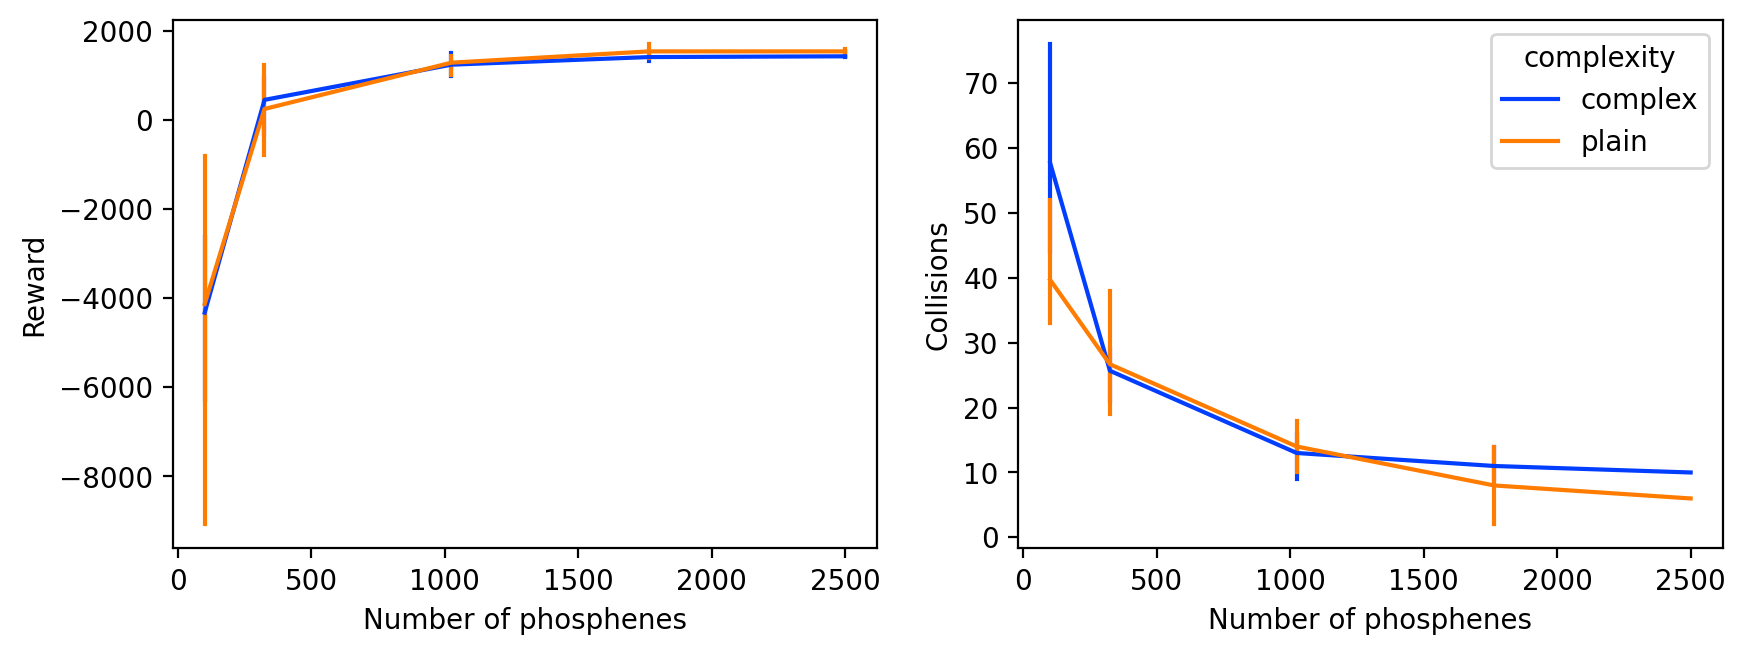

In [45]:
# plt.plot(test_results.phosphene_resolution,test_results.box_collisions,'.')

palette = sns.color_palette('bright', 2)
results = test_results.copy()

results.phosphene_resolution = results.phosphene_resolution**2

# endpoints = ['cumulative_reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']

endpoints = [('cumulative_reward', 'Reward'),('box_collisions', 'Collisions')]#,'wall_collisions', 'endless_loops']
fig, axs = plt.subplots(1,len(endpoints),figsize=(5*len(endpoints),3.5),dpi=200)
for i,(y,label) in enumerate(endpoints):
    ax = axs.flatten()[i]
    sns.lineplot(data=results.loc[results.light_intensity == 1], x='phosphene_resolution', y=y, hue='complexity', err_style='bars', ax=ax, palette=palette)
    ax.set( #xscale="log",
            ylabel = '{}'.format(label),
            xlabel = 'Number of phosphenes'
    )
            
    if i == 0:
        ax.legend().remove()
#         ax.set( yscale='log')
plt.show()

In [27]:
results.phosphene_resolution**2

model_name
exp0_comp_complex-seed_0-phos_10-edge_120       100
exp0_comp_complex-seed_0-phos_18-edge_120       324
exp0_comp_complex-seed_0-phos_32-edge_120      1024
exp0_comp_complex-seed_0-phos_42-edge_120      1764
exp0_comp_complex-seed_0-phos_50-edge_120      2500
exp0_comp_complex-seed_0-phos_none-edge_120     NaN
exp0_comp_complex-seed_1-phos_10-edge_120       100
exp0_comp_complex-seed_1-phos_18-edge_120       324
exp0_comp_complex-seed_1-phos_32-edge_120      1024
exp0_comp_complex-seed_1-phos_42-edge_120      1764
exp0_comp_complex-seed_1-phos_50-edge_120      2500
exp0_comp_complex-seed_1-phos_none-edge_120     NaN
exp0_comp_complex-seed_2-phos_10-edge_120       100
exp0_comp_complex-seed_2-phos_18-edge_120       324
exp0_comp_complex-seed_2-phos_32-edge_120      1024
exp0_comp_complex-seed_2-phos_42-edge_120      1764
exp0_comp_complex-seed_2-phos_50-edge_120      2500
exp0_comp_complex-seed_2-phos_none-edge_120     NaN
exp0_comp_plain-seed_0-phos_10-edge_120         100
e

In [34]:
import utils 

# write replay memory to video
videopath = os.path.join(OUT_PATH,'{}.avi'.format(current_model))
utils.save_replay(agent.memory.memory, videopath,(cfg['imsize'], cfg['imsize']))

In [9]:
def test2(agent, environment, img_processing, cfg):

    # Counters
    wall_collisions = 0
    box_collisions = 0
    endless_loops = 0
    step_count = 0
    cumulative_reward = 0
    side_steps = 0 # Side-step counter (to prevent endless loops)


    # Reset environment at start of episode
    _, _, _ = environment.reset(cfg['training_condition'])

    # Create an empty frame stack and fill it with frames
    frame_stack = imgproc.FrameStack(stack_size=cfg['stack_size'] )
    for _ in range(cfg['stack_size'] ):
        _, _, frame_raw = environment.step(0)
        frame = img_processing(frame_raw).to(agent.device)
        state = frame_stack.update_with(frame)

    # Episode starts here:
    agent_finished = False
    while not agent_finished:

        # 1. Agent performs a step (based on the current state) and obtains next state
        action = agent.select_action(state, validation=True)
        side_steps = side_steps + 1  if action != 0 else 0
        if side_steps > cfg['reset_after_nr_sidesteps']:
            endless_loops +=1
            action = torch.zeros_like(action) # force forward step
            side_steps = 0

        end, reward, frame_raw = environment.step(action.item())
        agent_finished = cfg['reset_end_is_{}'.format(end)]
        frame = img_processing(frame_raw).to(agent.device)
        next_state = frame_stack.update_with(frame) if not agent_finished else None

        # 2. Interpret reward signal
        if reward > 100:
            reward = -(reward -100)

        # 3. Store performance and training measures
        step_count += 1
        cumulative_reward += reward;
        if end == 1:
            box_collisions += 1
        if end == 2:
            wall_collisions +=1
            
        # 3. Push the transition to replay memory (in the right format & shape)
        reward = torch.tensor([reward], device=agent.device,dtype=torch.float)
        action = action.unsqueeze(0)
        agent.memory.push(state, action, next_state, reward)
        if next_state is not None:
            state = next_state.clone()

    return {'wall_collisions':wall_collisions,
            'box_collisions' :box_collisions,
            'endless_loops' :endless_loops,
            'step_count' :step_count,
            'cumulative_reward' :cumulative_reward}


In [12]:
test_results

,Unnamed: 0,status,complexity,seed,phosphene_resolution,edge_threshold,name,descr,fwd_reward,side_reward,...,target_update,memory_capacity,mode,training_condition,model_path,wall_collisions,box_collisions,endless_loops,step_count,cumulative_reward
model_name,,,,,,,,,,,,,,,,,,,,,
exp2-edgethr_comp_complex-seed_0-phos_26-edge_1,0.0,finished,complex,0,26,1,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,4,27,4,303,959
exp2-edgethr_comp_complex-seed_0-phos_26-edge_3,1.0,finished,complex,0,26,3,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,13,30,3,334,646
exp2-edgethr_comp_complex-seed_0-phos_26-edge_10,2.0,finished,complex,0,26,10,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,36,32,7,405,281
exp2-edgethr_comp_complex-seed_0-phos_26-edge_32,3.0,finished,complex,0,26,32,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,14,31,0,315,720
exp2-edgethr_comp_complex-seed_0-phos_26-edge_100,4.0,finished,complex,0,26,100,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,9,14,1,298,1207
exp2-edgethr_comp_complex-seed_0-phos_26-edge_316,5.0,finished,complex,0,26,316,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,40,30,18,505,284
exp2-edgethr_comp_complex-seed_0-phos_26-edge_1000,6.0,finished,complex,0,26,1000,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,0,21,0,196,1170
exp2-edgethr_comp_complex-seed_0-phos_26-edge_3162,NaN,finished,complex,0,26,3162,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,0,16,0,196,1320
exp2-edgethr_comp_complex-seed_1-phos_26-edge_1,NaN,finished,complex,1,26,1,exp2-edgethr,alexnet evaluation of edge threshold,10,-1,...,50000,36000,edge-detection,1,C:\Users\Jaap\Desktop\NESTOR\RL-mobility\Pytho...,6,21,0,243,1094


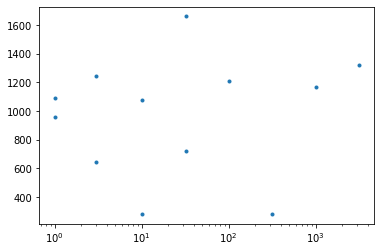

In [14]:
SAVE_FIG = None #"C:\\Users\\Jaap\\Desktop\\NESTOR\\_C_RL_mobility\\Materials\\Figures\exp2_results_complex-env_light-intensity05.png" # None

# output_metrics = [('cumulative_reward', 'Reward'),
#           ('step_count', 'Step count'),
#           ('wall_collisions', 'Number of wall-collisions '),
#           ('box_collisions', 'Number of box-collisions '),
#           ('endless_loops', 'Endless loops')]

# fig,axs= plt.subplots(1,len(output_metrics), figsize=(10*len(output_metrics),6), dpi=200)

# for i, (y,y_lbl) in enumerate(output_metrics):
#     sns.lineplot(data=test_results.loc[test_results.light_intensity == 1.0], x='edge_threshold',
#                  y=y, hue='phosphene_resolution', err_style='bars', ax=axs[i])
#     axs[i].set(title = '{}'.format(y_lbl),
#                ylabel = y_lbl)
                
# plt.show()

# if SAVE_FIG is not None:
#     fig.savefig(SAVE_FIG)

plt.semilogx(test_results.edge_threshold,test_results.cumulative_reward, '.')

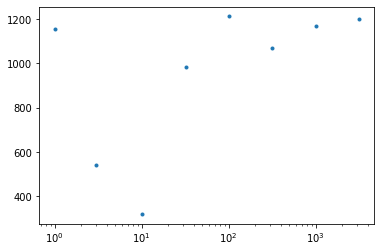

In [18]:
data = test_results.groupby('edge_threshold').mean()
plt.semilogx(data.index,data.cumulative_reward, '.')

In [19]:
data

,seed,phosphene_resolution,fwd_reward,side_reward,box_reward,wall_reward,target_step_reward,n_target_steps,light_intensity,lr_dqn,...,eps_delta,replay_start_size,target_update,memory_capacity,training_condition,wall_collisions,box_collisions,endless_loops,step_count,cumulative_reward
edge_threshold,,,,,,,,,,,,,,,,,,,,,
1,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,6.333333,18.333333,0.333333,256.000000,1152.666667
3,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,22.666667,31.333333,5.666667,342.000000,539.666667
10,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,41.333333,28.333333,8.333333,350.000000,320.000000
32,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,14.333333,21.000000,4.333333,293.333333,982.000000
100,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,5.000000,17.000000,0.333333,248.666667,1211.333333
316,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,4.333333,22.000000,3.666667,318.000000,1071.000000
1000,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,0.000000,21.000000,0.000000,196.333333,1169.666667
3162,1.0,26.0,10.0,-1.0,-20.0,-15.0,250.0,200.0,1.0,0.001,...,-0.000113,1500.0,50000.0,36000.0,1.0,0.000000,20.000000,0.000000,196.000000,1200.000000


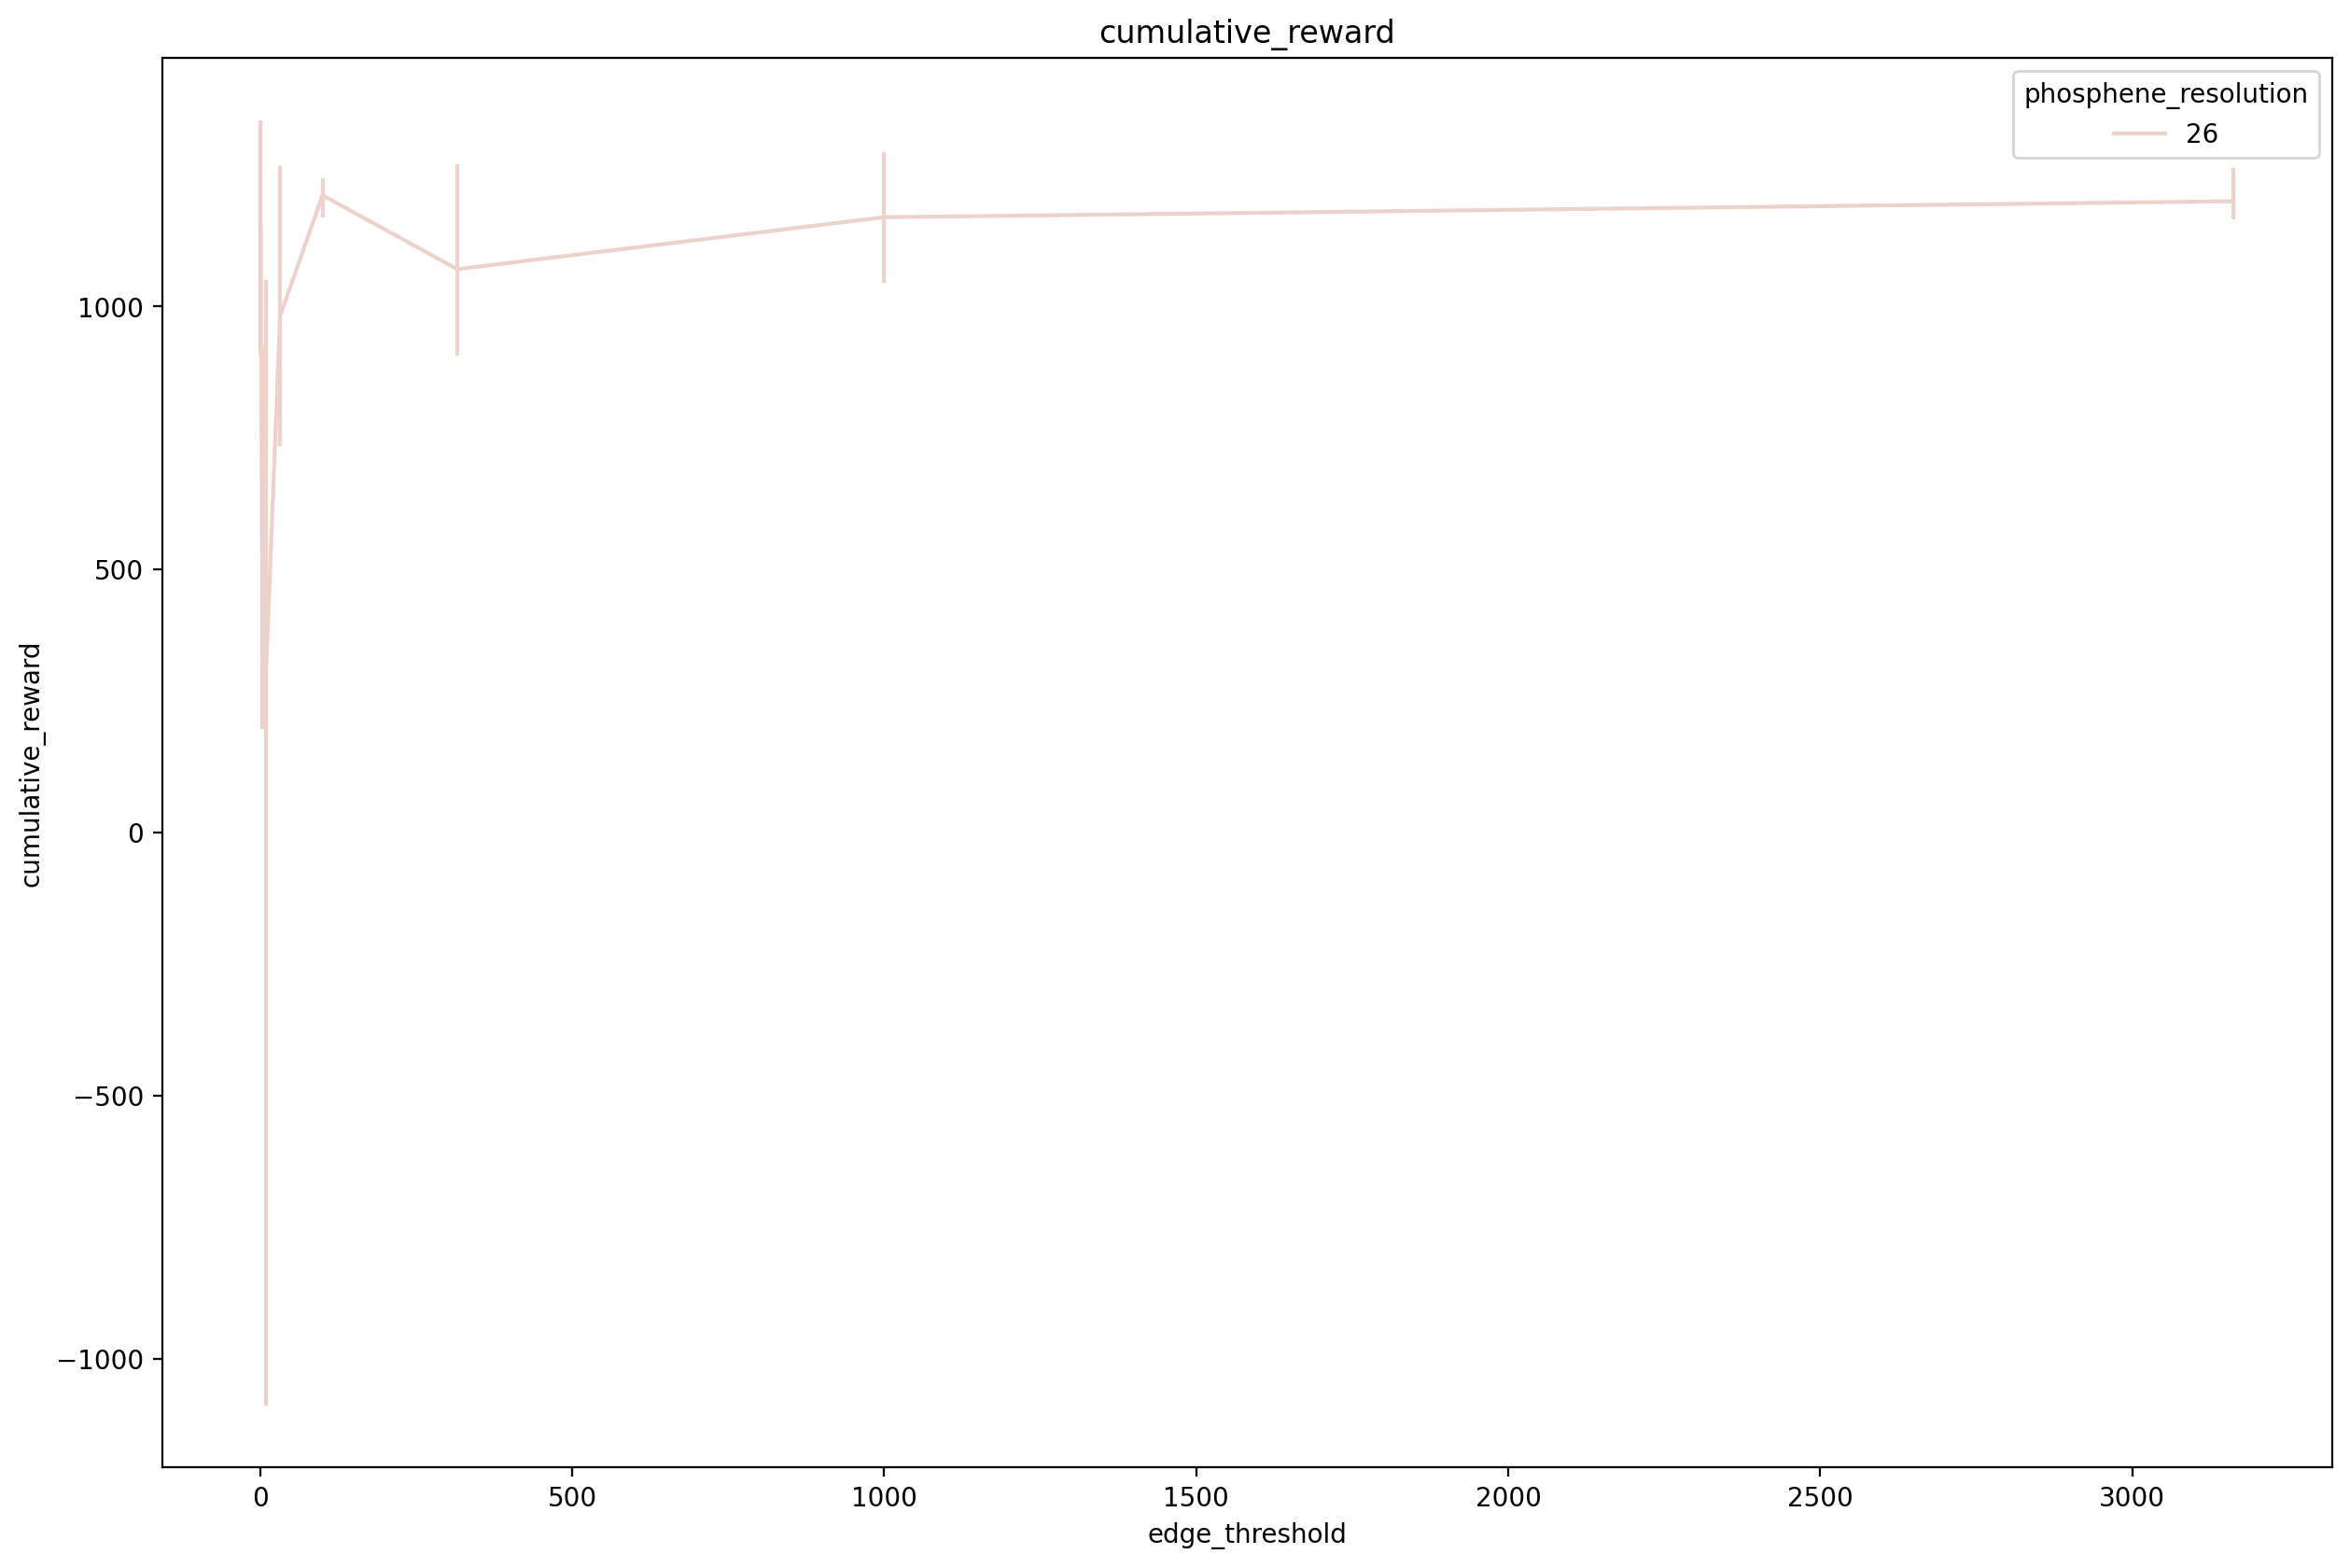

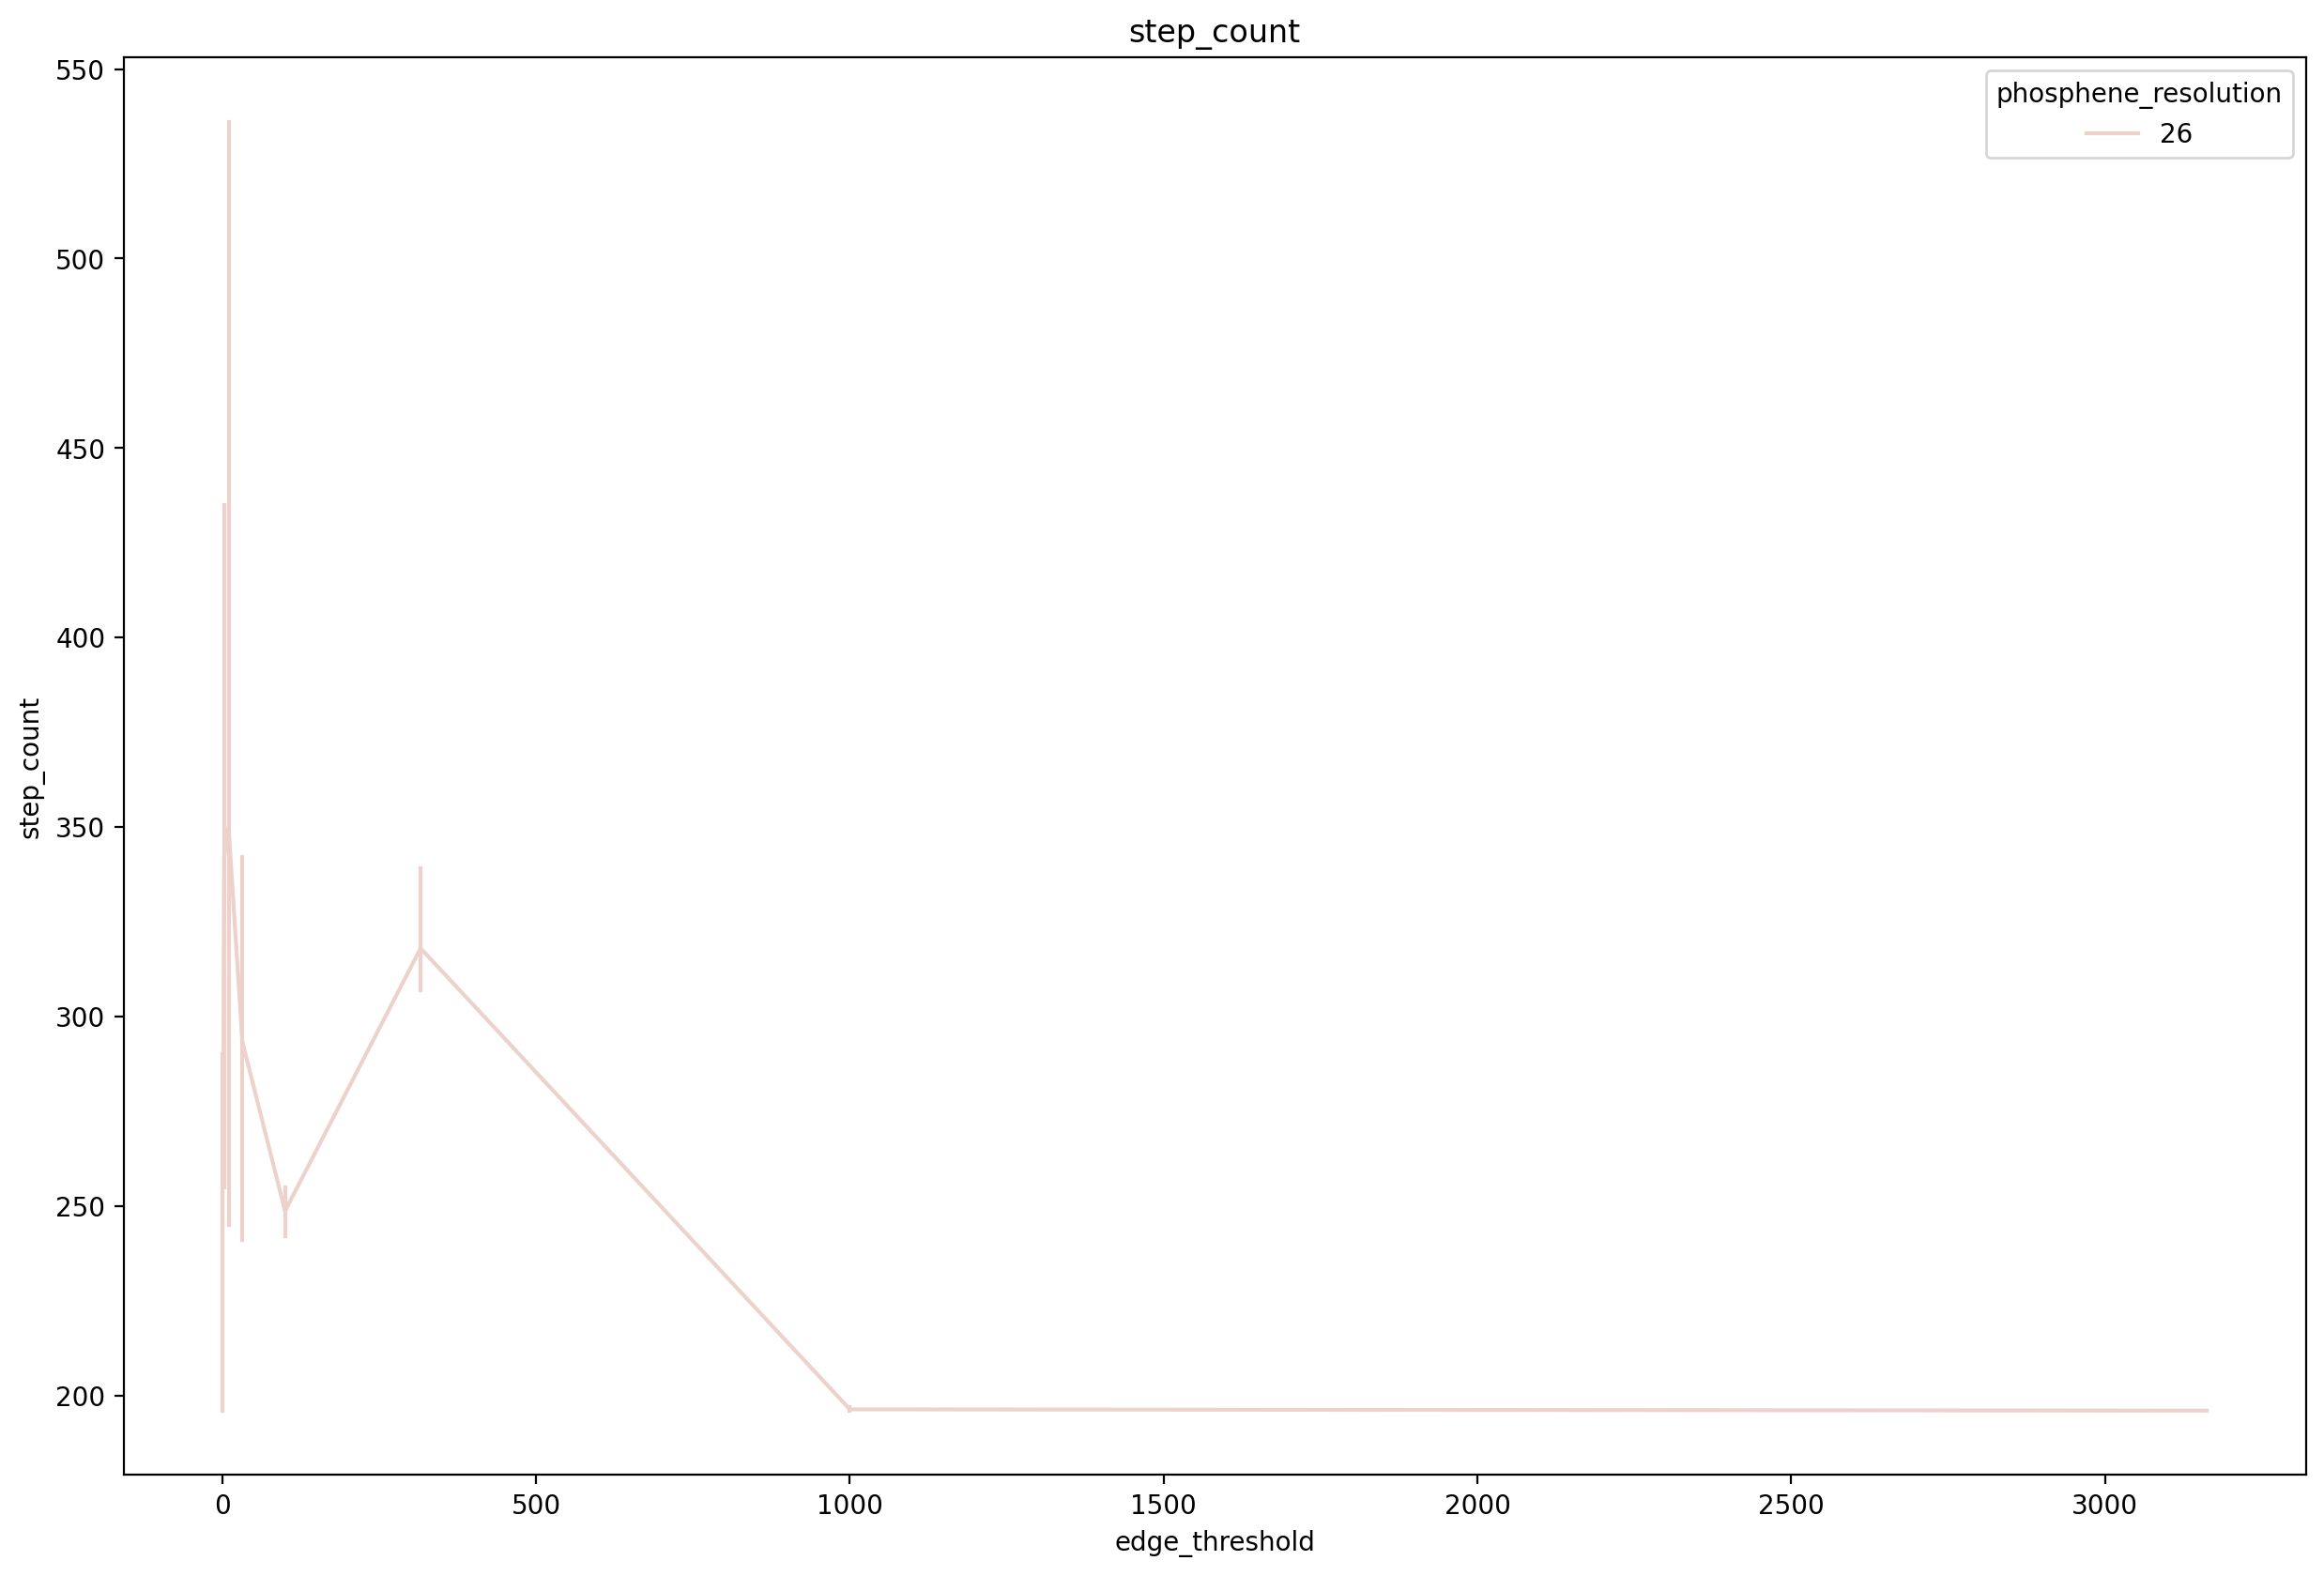

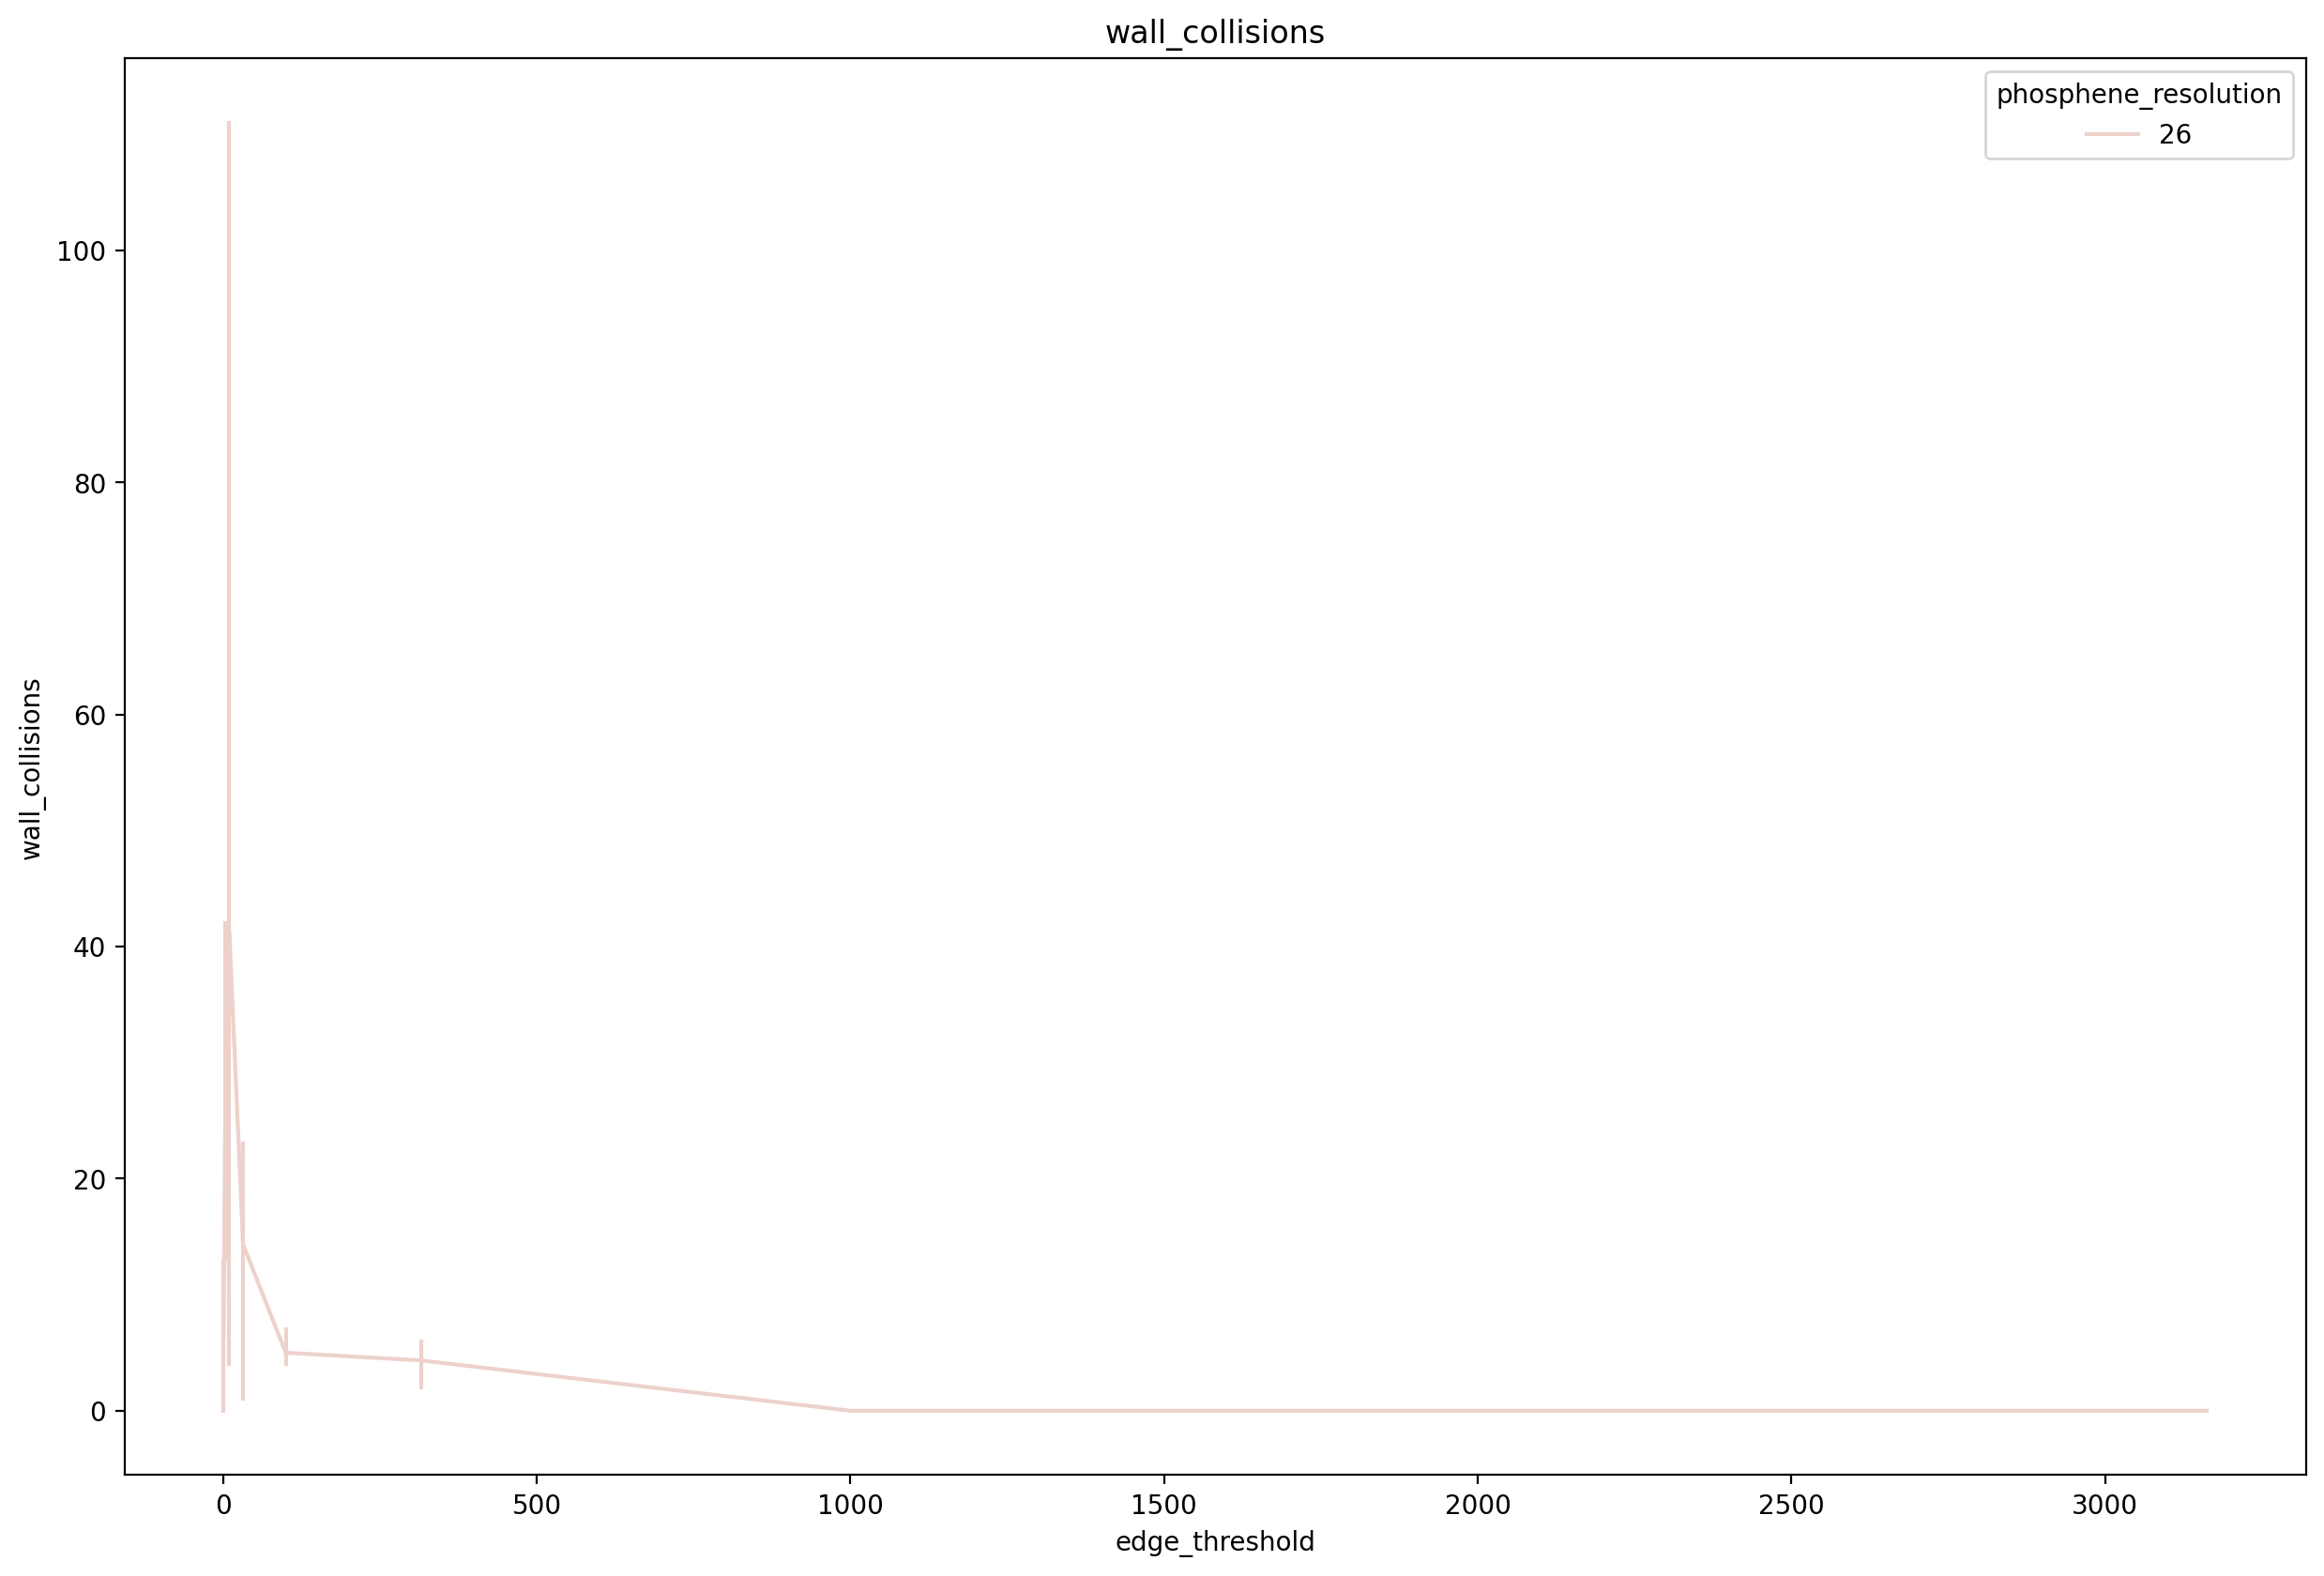

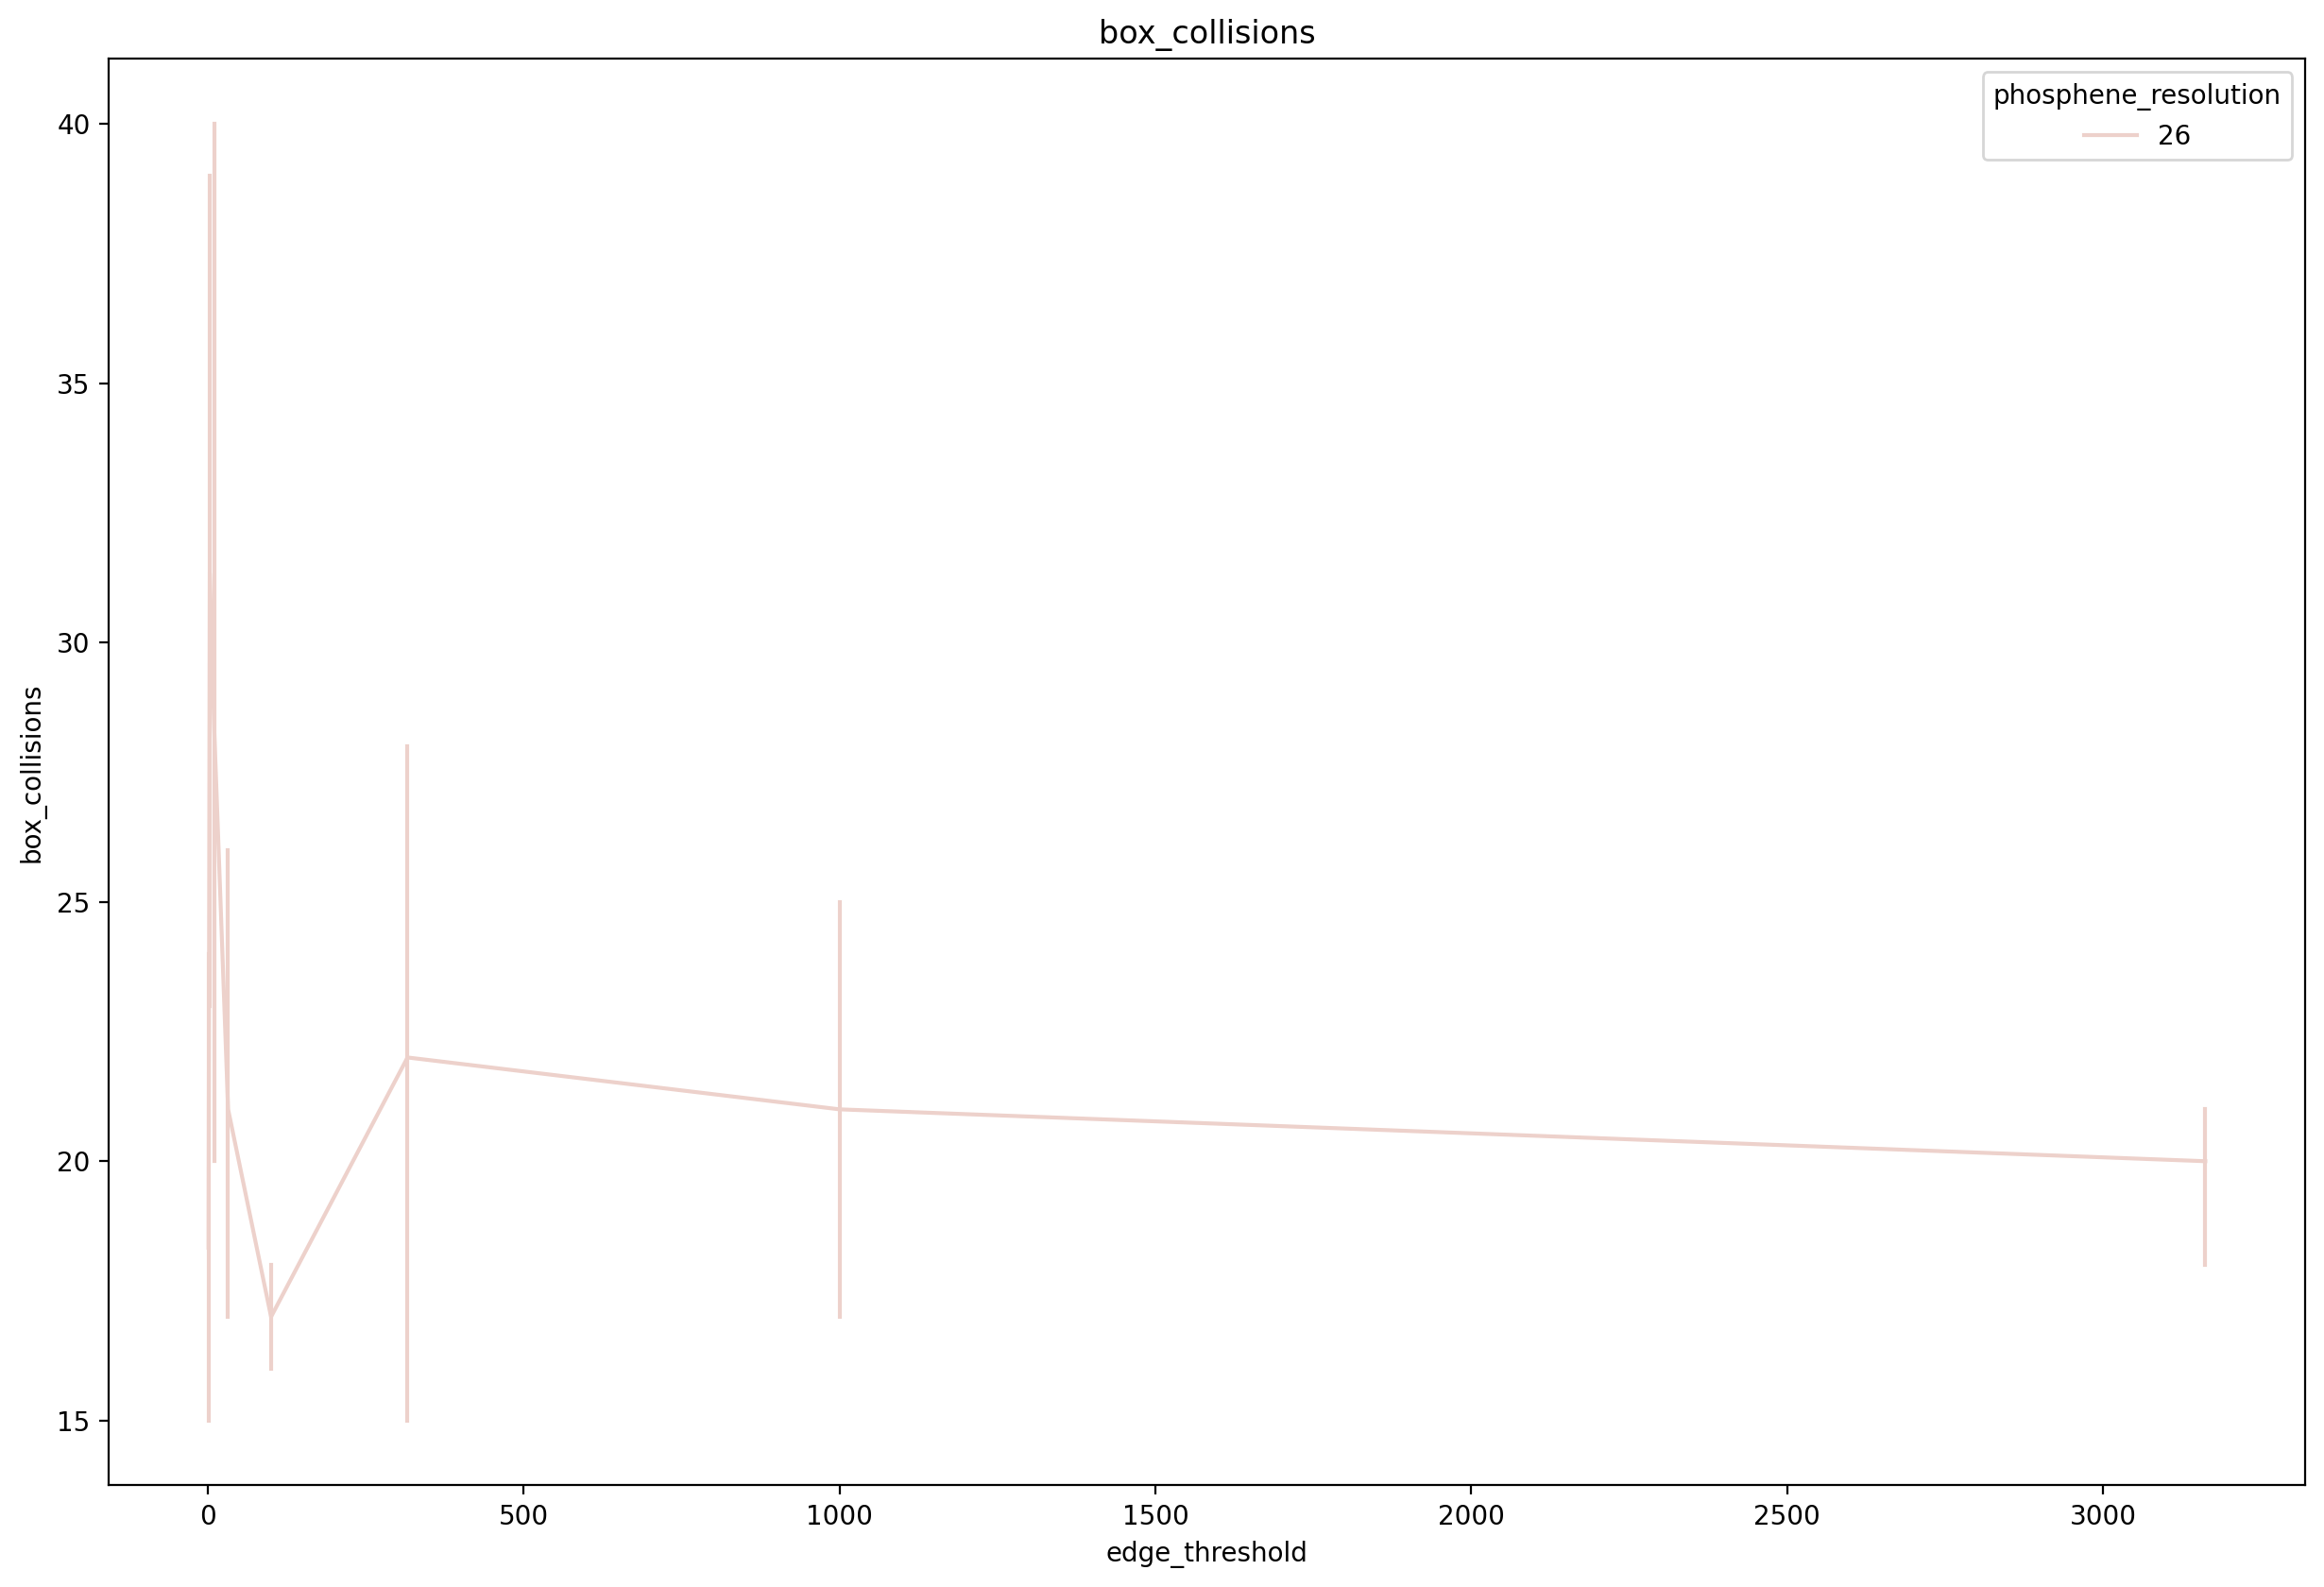

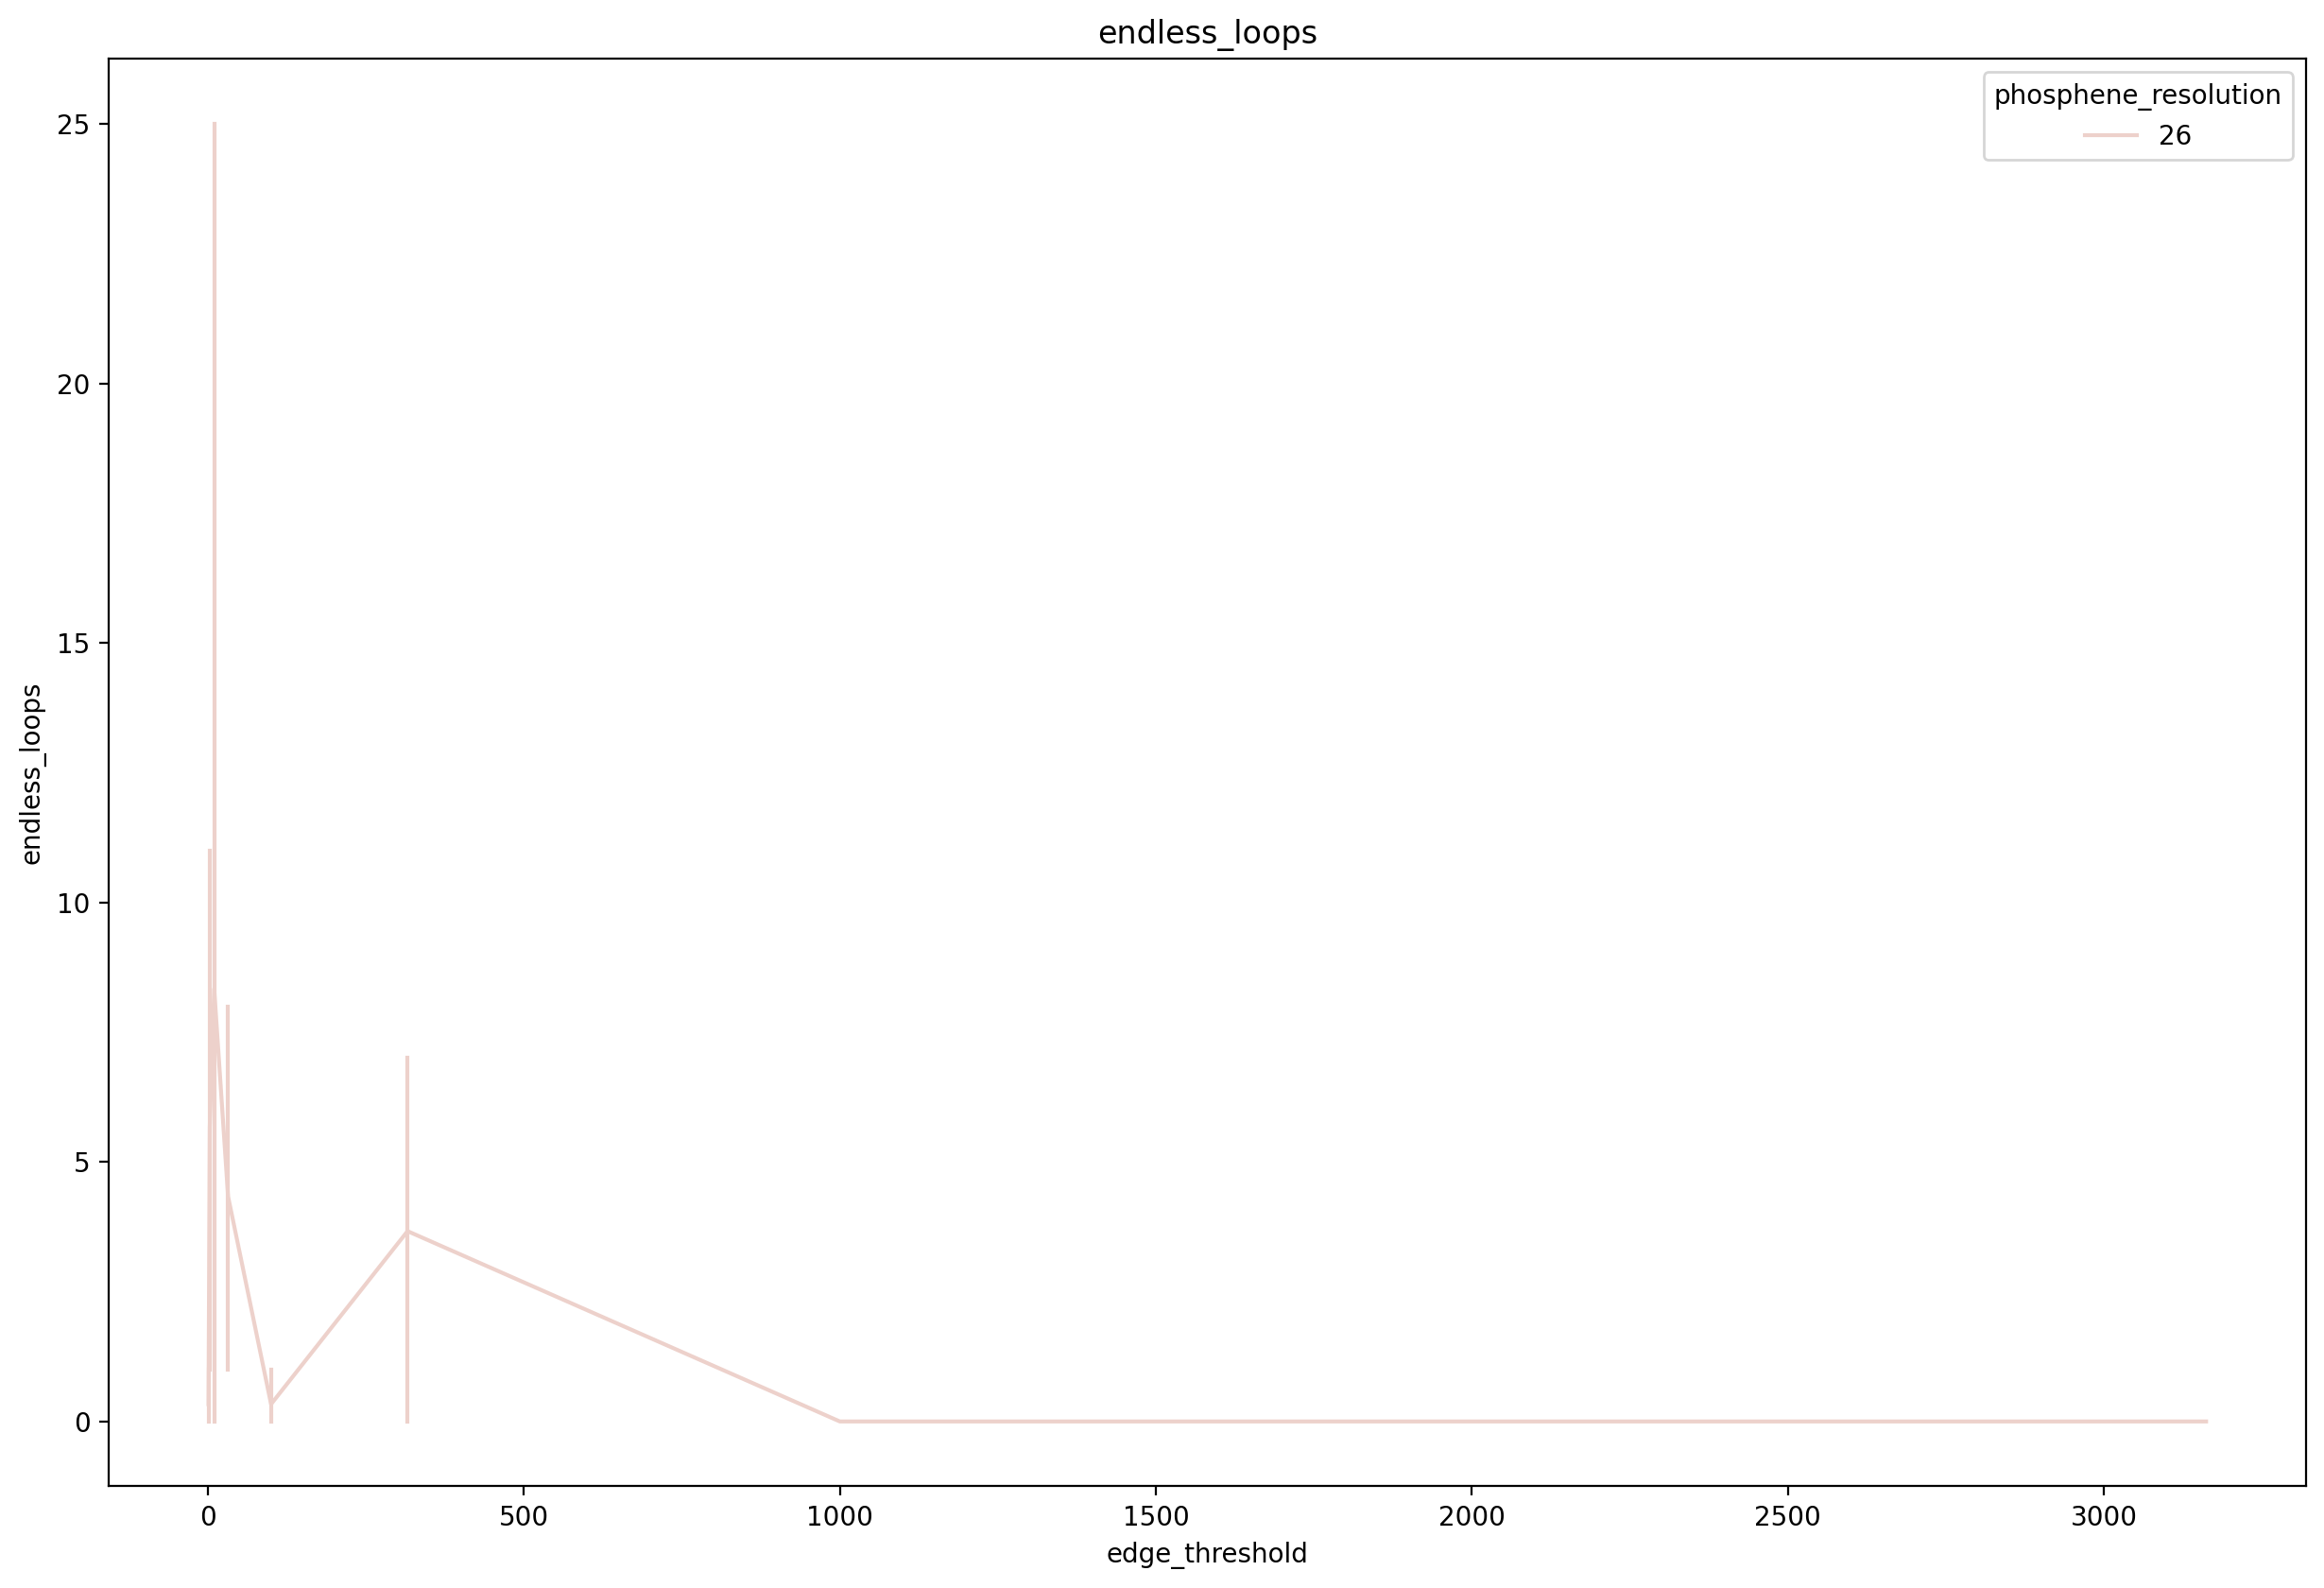

In [17]:

for y in ['cumulative_reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']:
    plt.figure(figsize=(15,10),dpi=200)
    sns.lineplot(data=test_results.loc[test_results.light_intensity == 1], x='edge_threshold', y=y, hue='phosphene_resolution', err_style='bars')
    plt.title('{}'.format(y))
    plt.show()